In [1]:
!pip install --upgrade -q packaging>=24 ordered-set>=3.1.1 more_itertools>=8.8 jaraco.text>=3.7 importlib_resources>=5.10.2 importlib_metadata>=6 tomli>=2.0.1 wheel>=0.43.0 platformdirs>=2.6.2

In [2]:
!pip install -q -U claudette python-fastdata

In [ ]:
!pip install -q -U datasets anthropic tqdm boto3 uuid pyyaml

In [28]:
! rm -rf src/hebrew_text_retrieval
!git clone https://github.com/asafam/hebrew_text_encoder.git src/hebrew_text_retrieval

Cloning into 'src/hebrew_text_retrieval'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 309 (delta 60), reused 76 (delta 34), pack-reused 201 (from 1)
Receiving objects: 100% (309/309), 67.93 MiB | 45.71 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Updating files: 100% (47/47), done.


In [ ]:
from typing import Optional
import os
import sys
import random
from datasets import Dataset, DatasetDict, load_dataset
from tqdm.notebook import tqdm
import time
from datetime import datetime
import pickle
from anthropic import AnthropicBedrock
import ast
import os
import boto3
import logging
import random
from pathlib import Path
from claudette import *
from fastcore.utils import *
import uuid
import requests
import json
import pandas as pd
import yaml

In [6]:
project_dir = '/home/ec2-user/SageMaker/sandbox/htr'
src_dir = os.path.join(project_dir, 'src')

os.chdir(project_dir)
print(f"Current working directory set to: {os.getcwd()}")
    
    
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)  # Add it to the front of PYTHONPATH
    print(f"PYTHONPATH updated with: {project_dir}")

Current working directory set to: /home/ec2-user/SageMaker/sandbox/htr
PYTHONPATH updated with: /home/ec2-user/SageMaker/sandbox/htr


## Data helper code

In [ ]:
def to_dataframe(dataset):
    # Create an empty list to store the dataframes
    dfs = []

    # Loop through the list of csv files
    for split in dataset.keys():
        # Read the csv file into a dataframe
        split_df = dataset[split].to_pandas()
        split_df['split'] = split
        
        # Append the dataframe to the list
        dfs.append(split_df)

    # Concatenate all dataframes in the list into a single dataframe
    source_df = pd.concat(dfs, ignore_index=True)
    print("source_df.shape =", source_df.shape)
    source_df.head()
    return source_df

### HEQ Data

In [ ]:
def _load_json_from_github(url):
    logger = logging.getLogger('default')
    logger.info(f"Loading json file from {url}")

    response = requests.get(url)
    if response.status_code == 200:
        content = json.loads(response.content)
        return content['data']
    else:
        print(f"Failed to fetch data from {url}")
        return None
    

def transform_entry(entry):
    return {
        'anchor_text': f"{TASK_TOKENS[TASK.QUESTION_PASSAGE]} {QUERY_TOKEN} {entry['question']}",
        'positive_text': f"{DOCUMENT_TOKEN} {entry['context']}",
        **entry
    }


def _transform_heq_entry(entry, index, split: str, should_sample: bool = True):
    items = []
    for j, paragraph in enumerate(entry['paragraphs']):
        if should_sample:
            qa_rand_idx = random.randint(0, len(paragraph['qas']) - 1)
            item = {
                'guid': str(uuid.uuid5(uuid.NAMESPACE_DNS, f"{split}-{j}-{qa_rand_idx}")),
                'index': index,
                'paragraph_index': j,
                'qa_index': qa_rand_idx,
                'source': entry['source'],
                'title': entry['title'],
                'question_id': paragraph['qas'][qa_rand_idx]['id'],
                'question': paragraph['qas'][qa_rand_idx]['question'],
                'answer': paragraph['qas'][qa_rand_idx]['answers'][0]['text'],
                'context': paragraph['context']
            }
            items.append(item)
        else:
            for qa_idx, qa in enumerate(paragraph['qas']):
                item = {
                    'guid': str(uuid.uuid5(uuid.NAMESPACE_DNS, f"{split}-{j}-{qa_idx}")),
                    'index': index,
                    'paragraph_index': j,
                    'qa_index': qa_idx,
                    'source': entry['source'],
                    'title': entry['title'],
                    'question_id': qa['id'],
                    'question': qa['question'],
                    'answer': qa['answers'][0]['text'],
                    'context': paragraph['context']
                }
                items.append(item)
    return items
    
    
def _transform_data(data, split: str, retrieve_task_normalize: bool = False, should_sample: bool = True, random_seed: int = 42):
    random.seed(random_seed)

    unflattened_transformed_heq_data = [_transform_heq_entry(entry=entry, index=index, should_sample=should_sample, split=split) for index, entry in enumerate(data)]
    # flatten the list
    transformed_heq_data = []
    for sublist in unflattened_transformed_heq_data:
        transformed_heq_data += sublist

    if retrieve_task_normalize:
        transformed_dataset_data = list(map(transform_entry, transformed_heq_data))
        dataset =  Dataset.from_list(transformed_dataset_data)
    else:
        dataset =  Dataset.from_list(transformed_heq_data)
        
    return dataset


def load_dataset_heq():
    data_files_url_base_path = 'https://raw.githubusercontent.com/NNLP-IL/Hebrew-Question-Answering-Dataset/main/data'
    splits = ['train', 'validation', 'test']
    split_file_mapping = {
        'validation': 'val',
    }
    datasets = {}
    for split in splits:
        file_split = split_file_mapping.get(split, split)
        url = f"{data_files_url_base_path}/{file_split}.json"
        print(f"url = {url}")
        data = _load_json_from_github(url=url)
        datasets[split] = _transform_data(
            data, split=split, retrieve_task_normalize=False, should_sample=False, random_seed=42
        )
    return datasets

url = https://raw.githubusercontent.com/NNLP-IL/Hebrew-Question-Answering-Dataset/main/data/train.json
url = https://raw.githubusercontent.com/NNLP-IL/Hebrew-Question-Answering-Dataset/main/data/val.json
url = https://raw.githubusercontent.com/NNLP-IL/Hebrew-Question-Answering-Dataset/main/data/test.json


## Syntehsize data
### Prompts

In [ ]:
# Path to your YAML file
# prompts_yaml_file_path = 'src/hebrew_text_retrieval/prompts/transform_qa/prompt_v20241127.yml'
prompts_yaml_file_path = 'src/hebrew_text_retrieval/prompts/transform_qa/prompt_v20241209.yml'

# Open and load the YAML file
with open(prompts_yaml_file_path, 'r') as file:
    prompts = yaml.safe_load(file)

## claudette

In [ ]:
ab = AnthropicBedrock()
model_id = models_aws[-2] # 'anthropic.claude-3-sonnet-20240229-v1:0'
cli = Client(model_id, ab)

In [ ]:
class AnswerabilityClassification():
    "Classification whether a question in answerable in the context"
    def __init__(self, context: str, question: str, classification: str, explanation: str): 
        store_attr()
        
    def __repr__(self): 
        return f"Context: {self.context}\nQuestion: {self.question}\nClassification:{self.classification}\nExplanation:{self.explanation}"

    
class ValidQuestionClassification():
    "Classification whether a question is valid"
    def __init__(self, question: str, classification: str, explanation: str): 
        store_attr()
        
    def __repr__(self): 
        return f"Question: {self.question}\nClassification:{self.classification}\nExplanation:{self.explanation}"

    
class RetrievalQuestion():
    "Edited retrieval question for a given context"
    def __init__(self, context: str, question: str, answer: str, edited_question: str, edit: str): 
        store_attr()
        
    def __repr__(self): 
        return f"Context: {self.context}\nQuestion: {self.question}\nAnswer: {self.answer}\nEdited question: {self.edited_question}\nEdit: {self.edit}"


def synthesize(system_prompt, user_prompt, tools, temperature=1):
    result = cli.structured(
        user_prompt, 
        sp=system_prompt, 
        temp=temperature, 
        tools=tools
    )[0]
    return result


def classify_answerability(context:str, question: str, answer: str) -> AnswerabilityClassification:
    task_prompts = prompts['answerable_question_classification']
    system_prompt = task_prompts['system_prompt']
    user_prompt = task_prompts['user_prompt'].format(
        context=context, question=question, answer=answer
    )
    
    return synthesize(
        system_prompt,
        user_prompt,
        temperature=0.2,
        tools=AnswerabilityClassification
    )
    
    
def classify_valid_question(context:str, question: str) -> ValidQuestionClassification:
    task_prompts = prompts['valid_question_classification']
    system_prompt = task_prompts['system_prompt']
    user_prompt = task_prompts['user_prompt'].format(context=context, question=question)
    
    return synthesize(
        system_prompt,
        user_prompt,
        temperature=0.6,
        tools=ValidQuestionClassification
    )
    
    
def edit_question(context:str, question: str, answer: str) -> RetrievalQuestion:
    task_prompts = prompts['question_edit']
    system_prompt = task_prompts['system_prompt']
    user_prompt = task_prompts['user_prompt'].format(
        context=context, question=question, answer=answer
    )
    
    return synthesize(
        system_prompt,
        user_prompt,
        temperature=0.8,
        tools=RetrievalQuestion
    )


def run_retrieval_questions_pipline(
    context:str, question: str, answer:str, temperature: float = 0.8,
    validate_answerability: bool = False, validate_question: bool = True,
    stop_on_no_answer: bool = False, stop_on_edit_not_required: bool = False,
    **kwargs
) -> dict:
    payload = dict(
        context=context,
        question=question,
        answer=answer,
        create_datetime = datetime.now()
    )
    result = dict(payload=payload)
    
    # Classify if a question is answerable
    if validate_answerability:
        answerable_classification = classify_answerability(
            context=context, question=question, answer=answer
        )
        result['answerable_question_classification'] = answerable_classification
        if stop_on_no_answer and answerable_classification.classification == "Invalid":
            return result
    
    # Classify if a question is valid
    if validate_question:
        valid_question_classification = classify_valid_question(question=question)
        result['valid_question_classification'] = valid_question_classification
        if stop_on_edit_not_required and valid_question_classification.classification == "Valid":
            return result
    
    # Edit the question
    edited_question = edit_question(
        context=context, question=question, answer=answer
    )
    result['edited_question'] = edited_question
    
    return result

In [13]:
def setup_logger(file_path: str, worker_id: Optional[None] = None):
    # Create or retrieve the logger
    logger = logging.getLogger('default')
    
    # Check if a handler with the given file_path already exists
    file_handler_exists = any(
        isinstance(handler, logging.FileHandler) and handler.baseFilename == os.path.abspath(file_path)
        for handler in logger.handlers
    )

    # Only add a new FileHandler if none exists for this file_path
    if file_handler_exists:
        logger.debug(f"Re-using logger writing to {file_path}")
        return logger
    
    logger.setLevel(logging.DEBUG)
    logger.propagate = False

    # Stream Handler (for console output)
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    log_format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    if worker_id is not None:
        log_format = f"[Worker %(process)d] {log_format}"
    formatter = logging.Formatter(log_format)
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # File Handler (for file output)
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    file_handler = logging.FileHandler(file_path)  # Log file name (you can specify the path)
    file_handler.setLevel(logging.DEBUG) # Set the log level for file handler
    file_handler.setFormatter(formatter) # Use the same formatter
    logger.addHandler(file_handler)
    
    logger.debug(f"Creating a new logger writing to {file_path}")

    return logger

In [ ]:
def run_pipeline(df, version, logger, data_file_path, sleep_time = 1):
    logger.info(f"Using AnthropicBedrock client for model {model_id}")

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Questions", unit="rows"):
        logger.info(f"Row {index+1} / {df.shape[0]}")
        
        # Check if we already created a question for the context
        if row['version'].notnull():
            logger.info(f"Alreay ran the pipeline on row at {index} (question with guid {row['guid']})")
            logger.info(f"Completed {index+1} / {len(df)} questions")
            continue
        
        # Run the pipeline
        start_datetime = datetime.now()
        result = run_retrieval_questions_pipline(
            context=row["context"],
            question=row["question"],
            answer=row["answer"]
        )
        logger.info(f"Completed a pipline run on an entry in {(datetime.now() - start_datetime).total_seconds():.2f} seconds")
        
        # Save data to file
        item = row.to_dict()
        start_datetime = datetime.now()
        payload = result['payload']
        item = dict(
            **item,
            **payload,
            version=version
        )
        
        answerable_question_classification = result['answerable_question_classification']
        item = dict(
            **item,
            no_answer_classification=answerable_question_classification.classification,
            no_answer_explananation=answerable_question_classification.explanation,
        )
        
        valid_question_classification = result['valid_question_classification']
        if valid_question_classification:
            item = dict(
                **item,
                edit_required_classification=valid_question_classification.classification,
                edit_required_explanation=valid_question_classification.explanation,
            )
            
        edited_question = result.get('edited_question')
        if edited_question:
            item = dict(
                **item,
                edited_question=edited_question.edited_question,
                retrieval_question_edit=edited_question.edit,
            )
        
        logger.info(f"context={item['context']}")
        logger.info(f"original question={item['question']}")
        logger.info(f"edited question={item.get('edited_question')}")
        logger.info(f"answer={item['answer']}")
        logger.info(f"edit={item.get('retrieval_question_edit', '')}")
        logger.info(f"answerable_question_classification={item.get('answerable_question_classification', '')}")
        logger.info(f"valid_question_classification={item.get('valid_question_classification', '')}")
        
        # update the df with the result data in item
        for key, value in item.items():
            df.at[index, key] = value

        # Create the data file path    
        Path(data_file_path).parent.mkdir(parents=True, exist_ok=True)
        # Save the file in CSV format
        df.to_csv(data_file_path, index=False)
        logger.info(f"Saved the data at {data_file_path} in {(datetime.now() - start_datetime).total_seconds():.2f} seconds")

        logger.info(f"Completed {index+1} / {len(df)} questions")
        
        # Sleep to avoid throttling blocks
        sleep_time = 5
        logger.info(f"Sleep for {sleep_time} second")
        time.sleep(sleep_time)
        logger.info("Woke up! Continuing process...")

2024-11-28 09:23:14,999 - default - INFO - dataset: heq


RetrievalQuestion tuples:   0%|          | 0/1504 [00:00<?, ?rows/s]

2024-11-28 09:23:15,008 - default - INFO - Row 1 / 1504
2024-11-28 09:24:10,181 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 55.17 seconds
2024-11-28 09:24:10,182 - default - INFO - context=בניית פרופילים של משתמשים נחשבת על ידי רבים כאיום פוטנציאלי על הפרטיות. מסיבה זו הגבילו חלק מהמדינות באמצעות חקיקה את המידע שניתן להשיג באמצעות עוגיות ואת אופן השימוש בעוגיות. ארצות הברית, למשל, קבעה חוקים נוקשים בכל הנוגע ליצירת עוגיות חדשות. חוקים אלו, אשר נקבעו בשנת 2000, נקבעו לאחר שנחשף כי המשרד ליישום המדיניות של הממשל האמריקאי נגד השימוש בסמים (ONDCP) בבית הלבן השתמש בעוגיות כדי לעקוב אחרי משתמשים שצפו בפרסומות נגד השימוש בסמים במטרה לבדוק האם משתמשים אלו נכנסו לאתרים התומכים בשימוש בסמים. דניאל בראנט, פעיל הדוגל בפרטיות המשתמשים באינטרנט, חשף כי ה-CIA שלח עוגיות קבועות למחשבי אזרחים במשך עשר שנים. ב-25 בדצמבר 2005 גילה בראנט כי הסוכנות לביטחון לאומי (ה-NSA) השאירה שתי עוגיות קבועות במחשבי מבקרים בגלל שדרוג תוכנה. לאחר שהנושא פורסם, הם ביטלו מיד את השימוש בהן.
2

2024-11-28 09:28:23,842 - default - INFO - original question=איזו סוכנות ביטלה את השימוש בעוגיות?
2024-11-28 09:28:23,843 - default - INFO - edited question=איזו סוכנות ממשלתית ביטלה את השימוש בעוגיות אחרי שהנושא פורסם?
2024-11-28 09:28:23,843 - default - INFO - answer=הסוכנות לביטחון לאומי
2024-11-28 09:28:23,843 - default - INFO - edit=BRIDGING
2024-11-28 09:28:23,843 - default - INFO - no_answer_classification=Answerable
2024-11-28 09:28:23,844 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 09:28:23,847 - default - INFO - Saving the data in 0.00 seconds
2024-11-28 09:28:23,847 - default - INFO - Completed 5 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 09:28:23,847 - default - INFO - Sleep for 5 second
2024-11-28 09:28:28,852 - default - INFO - Woke up! Continuing process...
2024-11-28 09:28:28,854 - default - INFO - Row 6 / 1504
2024-11-28 09:29:23,608 - default - INFO - Completed a Retri

2024-11-28 09:32:46,626 - default - INFO - original question=באיזו שנה גדל מספר הסוכנים ל-7029?
2024-11-28 09:32:46,626 - default - INFO - edited question=באיזו שנה גדל מספר סוכני ה-FBI ל-7,029?
2024-11-28 09:32:46,626 - default - INFO - answer=ב-1952
2024-11-28 09:32:46,627 - default - INFO - edit=BRIDGING
2024-11-28 09:32:46,627 - default - INFO - no_answer_classification=Answerable
2024-11-28 09:32:46,627 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 09:32:46,630 - default - INFO - Saving the data in 0.00 seconds
2024-11-28 09:32:46,630 - default - INFO - Completed 10 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 09:32:46,630 - default - INFO - Sleep for 5 second
2024-11-28 09:32:51,636 - default - INFO - Woke up! Continuing process...
2024-11-28 09:32:51,637 - default - INFO - Row 11 / 1504
2024-11-28 09:33:32,017 - default - INFO - Completed a RetrievalQuestion pipline run on an entry i

2024-11-28 09:37:23,855 - default - INFO - original question=מתי האשימו אלפי אזרחי ארצות הברית בקומוניזם?
2024-11-28 09:37:23,855 - default - INFO - edited question=מתי הואשמו אלפים מאזרחי ארצות הברית בחברות במפלגה הקומוניסטית או באהדה כלפיה?
2024-11-28 09:37:23,855 - default - INFO - answer=במהלך תקופת מקארתי
2024-11-28 09:37:23,856 - default - INFO - edit=BRIDGING
2024-11-28 09:37:23,856 - default - INFO - no_answer_classification=Answerable
2024-11-28 09:37:23,856 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 09:37:23,859 - default - INFO - Saving the data in 0.00 seconds
2024-11-28 09:37:23,859 - default - INFO - Completed 15 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 09:37:23,860 - default - INFO - Sleep for 5 second
2024-11-28 09:37:28,865 - default - INFO - Woke up! Continuing process...
2024-11-28 09:37:28,866 - default - INFO - Row 16 / 1504
2024-11-28 09:38:20,079 - default - IN

2024-11-28 09:41:11,621 - default - INFO - original question=כמה פסקי דין בוטלו?
2024-11-28 09:41:11,622 - default - INFO - edited question=כמה פסקי דין נגד אזרחים מואשמים בתקופת מקארתי בוטלו?
2024-11-28 09:41:11,622 - default - INFO - answer=אלפים
2024-11-28 09:41:11,622 - default - INFO - edit=GLOBAL SCOPING
2024-11-28 09:41:11,622 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 09:41:11,623 - default - INFO - edit_required_classification=Edit Required
2024-11-28 09:41:11,626 - default - INFO - Saving the data in 0.00 seconds
2024-11-28 09:41:11,626 - default - INFO - Completed 19 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 09:41:11,627 - default - INFO - Sleep for 5 second
2024-11-28 09:41:16,632 - default - INFO - Woke up! Continuing process...
2024-11-28 09:41:16,633 - default - INFO - Row 20 / 1504
2024-11-28 09:42:02,323 - default - INFO - Completed a RetrievalQuestion pipline run on an ent

2024-11-28 09:45:31,168 - default - INFO - original question=כמה יוני זרחה משוחררים?
2024-11-28 09:45:31,168 - default - INFO - edited question=כמה יוני זרחה משוחררים בתהליך קישור הגלוקוז ל-UDP?
2024-11-28 09:45:31,169 - default - INFO - answer=שני יוני זרחה
2024-11-28 09:45:31,169 - default - INFO - edit=BRIDGING
2024-11-28 09:45:31,170 - default - INFO - no_answer_classification=Answerable
2024-11-28 09:45:31,170 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 09:45:31,173 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 09:45:31,173 - default - INFO - Completed 24 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 09:45:31,174 - default - INFO - Sleep for 5 second
2024-11-28 09:45:36,179 - default - INFO - Woke up! Continuing process...
2024-11-28 09:45:36,180 - default - INFO - Row 25 / 1504
2024-11-28 09:46:32,835 - default - INFO - Completed a RetrievalQuestion pipline run on an 

2024-11-28 09:49:33,850 - default - INFO - Row 29 / 1504
2024-11-28 09:50:22,992 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 49.14 seconds
2024-11-28 09:50:22,993 - default - INFO - context=בתהליכי ההתהוות שלה, חדשנות משבשת נוצרת לא פעם תוך מתן מענה לפלח שוק קטן או לא משמעותי אשר לא קיבל מענה באמצעות החדשנות הדומיננטית עד כה. בשל כך, חדשנות משבשת מאופיינת בשלביה הראשונים בביצועים נחותים ביחס למה שהצרכנים של השוק המסורתי דורש אך יש לה יתרונות אחרים שלקוחות אחרים מעריכים. יתרונות אלו יכולים להיות בתחום המחיר, הנוחות, האפשרויות החדשות שהיא מאפשרת וכיוצא בזה. כך הטכנולוגיה המשבשת מתפתחת ומשתפרת מחוץ לרדאר של השחקנים הקיימים עד למצב (שיכול לקחת שנים ואף עשרות שנים) שהיא כבר אינה נחותה בביצועים שלקוחות המסורתיים מעריכים (כמו איכות קול בטלפון או איכות תמונה במצלמה או במדפסת). על כן, המושג חדשנות משבשת מתאר חידושים אשר משפרים את המוצר או השירות באופן שהשוק הקיים לא צפה, תחילה על ידי פניה לקבוצת צרכנים חדשה ואחר-כך על ידי הורדת מחירים בשוק הקיים.
2024-11-28 09:50

2024-11-28 09:54:23,499 - default - INFO - edited question=מה המשמעות של שיפורים "לא רציפים" בהקשר של חדשנות תומכת?
2024-11-28 09:54:23,500 - default - INFO - answer=רדיקלים/קיצוניים או מהפכניים
2024-11-28 09:54:23,500 - default - INFO - edit=BRIDGING
2024-11-28 09:54:23,500 - default - INFO - no_answer_classification=Answerable
2024-11-28 09:54:23,501 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 09:54:23,504 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 09:54:23,504 - default - INFO - Completed 33 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 09:54:23,505 - default - INFO - Sleep for 5 second
2024-11-28 09:54:28,510 - default - INFO - Woke up! Continuing process...
2024-11-28 09:54:28,511 - default - INFO - Row 34 / 1504
2024-11-28 09:55:14,344 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 45.83 seconds
2024-11-28 09:55:14,345 - default - INFO 

2024-11-28 09:58:36,255 - default - INFO - original question=מדוע התפצלה סיעת כחול לבן?
2024-11-28 09:58:36,255 - default - INFO - edited question=מדוע התפצלה סיעת "כחול לבן" בכנסת ה-23?
2024-11-28 09:58:36,256 - default - INFO - answer=מחלוקת סביב ההצטרפות לממשלת ישראל השלושים וחמש
2024-11-28 09:58:36,256 - default - INFO - edit=BRIDGING
2024-11-28 09:58:36,256 - default - INFO - no_answer_classification=Answerable
2024-11-28 09:58:36,257 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 09:58:36,260 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 09:58:36,261 - default - INFO - Completed 38 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 09:58:36,261 - default - INFO - Sleep for 5 second
2024-11-28 09:58:41,266 - default - INFO - Woke up! Continuing process...
2024-11-28 09:58:41,268 - default - INFO - Row 39 / 1504
2024-11-28 09:59:33,358 - default - INFO - Completed a RetrievalQu

2024-11-28 10:03:25,420 - default - INFO - edited question=מי היה ראש ממשלת ישראל בכנסת ה-23?
2024-11-28 10:03:25,421 - default - INFO - answer=תהלה פרידמן
2024-11-28 10:03:25,421 - default - INFO - edit=GLOBAL SCOPING
2024-11-28 10:03:25,421 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 10:03:25,422 - default - INFO - edit_required_classification=Edit Required
2024-11-28 10:03:25,427 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 10:03:25,427 - default - INFO - Completed 43 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 10:03:25,428 - default - INFO - Sleep for 5 second
2024-11-28 10:03:30,433 - default - INFO - Woke up! Continuing process...
2024-11-28 10:03:30,435 - default - INFO - Row 44 / 1504
2024-11-28 10:04:57,570 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 87.13 seconds
2024-11-28 10:04:57,571 - default - INFO - context=על פי מצע המפלגה שנכתב

2024-11-28 10:09:30,663 - default - INFO - original question=עפ"י המצע שנכתב בשנת 2013, מה יעלה בגורלו של סגן שר שישמור על זכות שתיקה בזמן חקירה פלילית?
2024-11-28 10:09:30,663 - default - INFO - edited question=לפי המצע שנכתב בשנת 2013, מה יעלה בגורלו של סגן שר שישמור על זכות השתיקה בזמן חקירה פלילית?
2024-11-28 10:09:30,663 - default - INFO - answer=לא יוכל להמשיך לכהן כנבחר ציבור בגלל סירובו לשיתוף פעולה עם רשויות המדינה והחוק
2024-11-28 10:09:30,663 - default - INFO - edit=DETERMINER EDITING
2024-11-28 10:09:30,664 - default - INFO - no_answer_classification=Answerable
2024-11-28 10:09:30,664 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 10:09:30,668 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 10:09:30,668 - default - INFO - Completed 47 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 10:09:30,668 - default - INFO - Sleep for 5 second
2024-11-28 10:09:35,674 - default - I

2024-11-28 10:15:02,967 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 56.07 seconds
2024-11-28 10:15:02,968 - default - INFO - context=ב-22 במאי 1948 תקפו ספיטפיירים מצרים את שדה התעופה ברמת דוד בהנחה מוטעית שהבריטים פינו אותו. לטענת המצרים הם התכוונו לתקוף את מנחת מגידו הסמוך ובטעות תקפו את רמת דוד. הם גרמו נזק למבנים, הוציאו מכלל שימוש מספר ספיטפיירים בריטים והרגו ארבעה בריטים. מוכי תדהמה וזעם העמידו הבריטים מספר מטוסים במצב הכן בהניחם כי הפוגעים בהם ישובו להתקפה נוספת. כעבור כחצי שעה הופיעה שוב להקה של ארבעה ספיטפיירים. הפעם קדמו אותם הבריטים באוויר ובקרב האווירי שהתחולל, הופלו שני ספיטפיירים מצרים ונגרם נזק לשניים אחרים. אחד הטייסים המצרים נחת נחיתת אונס ליד קיבוץ דליה ונפל בשבי כוחות צה"ל.
2024-11-28 10:15:02,969 - default - INFO - original question=כמה זמן עבר בין שתי ההופעות של המצרים מעל רמת דוד?
2024-11-28 10:15:02,969 - default - INFO - edited question=כמה זמן עבר בין שתי ההתקפות של מטוסי ספיטפייר מצרים על שדה התעופה ברמת דוד?
2024-11-28 10:15:02

2024-11-28 10:19:51,561 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 59.03 seconds
2024-11-28 10:19:51,562 - default - INFO - context=רמת דוד התחיל את דרכו כמנחת מאולתר בשדה תירס, ואחד הטייסים הראשונים שנחתו בו היה סופר הילדים רואלד דאל. הבסיס הצבאי ברמת-דוד הוקם בשנת 1937 על ידי הבריטים בתקופת המנדט הבריטי בארץ ישראל. זהו אחד הבסיסים אשר הוקמו כחלק מתשתיות חיל-האוויר המלכותי, ונועד לשמש כבסיס חלופי לבסיס חיפה שהותקף על ידי מטוסים גרמניים במהלך מלחמת העולם השנייה. שמו המקורי של הבסיס ברמת דוד היה "שדה לויד" על שם סר דייוויד לויד ג'ורג', מדינאי בריטי וראש ממשלת בריטניה. הבסיס מוקם בסמוך לתחנת רכבת העמק השוכנת על קו צינור הנפט שהוביל נפט מכירכוך שבצפון עיראק אל חיפה.
2024-11-28 10:19:51,563 - default - INFO - original question=מי התקיף את הבסיס בחיפה במהלך מלחמת העולם השנייה?
2024-11-28 10:19:51,563 - default - INFO - edited question=מי התקיף את בסיס חיל האוויר המלכותי בחיפה במהלך מלחמת העולם השנייה?
2024-11-28 10:19:51,563 - default - INFO - answer=מטוסים 

2024-11-28 10:24:52,029 - default - INFO - context=נוסף על הקרמבו התעשייתי הנמכר בחנויות ובקיוסקים קיימים גם מתכונים להכנת קרמבו ביתי, ומסעדות המציעות בתפריטן קינוח המהווה וריאציה על הקרמבו (ולרוב נקרא קרמבו או שם דומה). הקרמבו הביתי והקרמבו הנמכר במסעדות נעשים בדרך כלל מחומרים יקרים יותר ומתאפיינים במגוון טעמים ומרכיבים רחב יותר. המשותף להם הוא שמירה על הרכבת מנה מתחתית קשיחה העשויה מנוגט, בצק או אגוזים, אשר עליה קרם או קצפת בטעמים שונים וציפוי מתוק. קינוחי הקרמבו הללו עשויים להכיל פירות שונים, קפה, משקאות אלכוהוליים ומוצרי חלב ביניהם שמנת וחמאה.
2024-11-28 10:24:52,029 - default - INFO - original question=מהו הקרמבו שנמכר בחנויות?
2024-11-28 10:24:52,030 - default - INFO - edited question=מהו הקרמבו התעשייתי הנמכר בחנויות ובקיוסקים?
2024-11-28 10:24:52,030 - default - INFO - answer=הקרמבו התעשייתי
2024-11-28 10:24:52,030 - default - INFO - edit=BRIDGING
2024-11-28 10:24:52,031 - default - INFO - no_answer_classification=Answerable
2024-11-28 10:24:52,031 - default - INFO - edit_requi

2024-11-28 10:28:46,249 - default - INFO - Woke up! Continuing process...
2024-11-28 10:28:46,250 - default - INFO - Row 67 / 1504
2024-11-28 10:29:53,932 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 67.68 seconds
2024-11-28 10:29:53,933 - default - INFO - context=במאה השש עשרה החל המונח "לבנט" להיות שגור גם כלפי אזורים שבשליטת האימפריה העות'מאנית במזרח הים התיכון, ומאוחר יותר התרחב והחל לכלול גם שטחים נוספים שתחת שליטת העות'מאנים, כמו יוון וחופי אסיה הקטנה. המונח "לבנטיני" (Levantine) שימש בעיקר לתיאור בני עמים מאגן הים התיכון, כמו איטלקים (בפרט אנשי ונציה וג'נובה, בעלי העניין המסחרי והדתי באזור), צרפתים ובני עמים ים-תיכוניים שחיו באימפריה העות'מאנית. כאשר קיבלה בריטניה מנדט על שטחי פלשתינה (ארץ ישראל) אחרי מלחמת העולם הראשונה, השתמשו חלק מהבריטים בתואר "לבנטיני" ככינוי גנאי לתושבים ממוצא ערבי-אירופי מעורב, וכן לגבי צרפתים, איטלקים או יוונים שהתאקלמו במזרח התיכון ואימצו לבוש ומנהגים מזרחיים.
2024-11-28 10:29:53,933 - default - INFO - original question=מה

2024-11-28 10:34:49,064 - default - INFO - original question=מי היה הכוח המסתער לאחר פתיחת מבצע שלום הגליל?
2024-11-28 10:34:49,064 - default - INFO - edited question=מי היה הכוח המסתער שהלך יחד עם התותחנים לאחר פתיחת מבצע שלום הגליל?
2024-11-28 10:34:49,064 - default - INFO - answer=כוח צנחנים
2024-11-28 10:34:49,065 - default - INFO - edit=BRIDGING
2024-11-28 10:34:49,065 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 10:34:49,065 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 10:34:49,070 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 10:34:49,070 - default - INFO - Completed 71 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 10:34:49,070 - default - INFO - Sleep for 5 second
2024-11-28 10:34:54,076 - default - INFO - Woke up! Continuing process...
2024-11-28 10:34:54,077 - default - INFO - Row 72 / 1504
2024-11-28 10:36:15,305 - default - INFO - Complet

2024-11-28 10:40:03,555 - default - INFO - context=גברים ונשים המיועדים לשירות ביטחון, בעלי נתונים אישיים מתאימים, מזומנים למיוני צוות ים בשלוש דרכים. האחת היא זימון ישיר למיון, השנייה היא איתור דרך יום סיירות (בתנאי שהמועמד עומד בתנאים הבסיסיים) והשלישית היא דרך גדנ"ע חובלים המתקיימת אחת או פעמיים בשנה, כתלות בביקוש. לאחר מכן מוזמנים המועמדים ליום מיון בביתן חיל הים בבסיס חיל הים בחיפה. יום מיון זה כולל מבחנים פסיכוטכניים ופסיכולוגיים אשר מטרתם לנבא את יכולות המועמד בטרם הגיבוש. מועמדים שנמצאו מתאימים מוזמנים לגיבוש בן ארבעה ימים הנערך בבה"ד חיל הים בחיפה טרם הגיוס, וכולל מאמץ גופני ונפשי, מבחני ידע בנושאים שונים, מבחני דינמיקה קבוצתית ומשימות פיקודיות רבות. אחוז העוברים את הגיבוש נחשב נמוך יחסית.
2024-11-28 10:40:03,556 - default - INFO - original question=מה קורה ביום המיון בבסיס חיל הים בחיפה?
2024-11-28 10:40:03,556 - default - INFO - edited question=מה קורה ביום המיון לצוות ים בביתן חיל הים בבסיס חיל הים בחיפה?
2024-11-28 10:40:03,557 - default - INFO - answer=מבחנים פסיכוטכניים 

2024-11-28 10:44:02,387 - default - INFO - Completed 80 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 10:44:02,388 - default - INFO - Sleep for 5 second
2024-11-28 10:44:07,393 - default - INFO - Woke up! Continuing process...
2024-11-28 10:44:07,395 - default - INFO - Row 81 / 1504
2024-11-28 10:44:49,591 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 42.20 seconds
2024-11-28 10:44:49,592 - default - INFO - context=על מנת לעבור את הבוחן על הצוער לקבל 60 נקודות ולהצליח לפגוע בשתי מטרות. החובלים עומדים בקו הזינוק, מחולקים לשלשות, בידו של כל אחד מפה שונה בשביל שהניווט באמת יהיה עצמאי. משימתם היא להגיע לכל הנקודות בזמן מוקצב, שעה וארבעים וחמש דקות, וככל שעושים זאת יותר מהר צוברים יותר נקודות. אורך הניווט 6 ק"מ במהלכו החובלים צריכים למצוא לפחות ארבע מתוך שמונה נקודות בשביל לעמוד בהישג הנדרש. לאחר שעברו את הניווט וצלחו את המתקנים, הם עומדים בשורה ומחכים להזנקה לעבר היל"ם (ירי לאחר מאמץ). לרשותם דק

2024-11-28 10:48:12,829 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 10:48:12,830 - default - INFO - Completed 85 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 10:48:12,830 - default - INFO - Sleep for 5 second
2024-11-28 10:48:17,835 - default - INFO - Woke up! Continuing process...
2024-11-28 10:48:17,837 - default - INFO - Row 86 / 1504
2024-11-28 10:49:14,513 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 56.68 seconds
2024-11-28 10:49:14,514 - default - INFO - context=על מנת לעבור את הבוחן על הצוער לקבל 60 נקודות ולהצליח לפגוע בשתי מטרות. החובלים עומדים בקו הזינוק, מחולקים לשלשות, בידו של כל אחד מפה שונה בשביל שהניווט באמת יהיה עצמאי. משימתם היא להגיע לכל הנקודות בזמן מוקצב, שעה וארבעים וחמש דקות, וככל שעושים זאת יותר מהר צוברים יותר נקודות. אורך הניווט 6 ק"מ במהלכו החובלים צריכים למצוא לפחות ארבע מתוך שמונה נקודות בשביל לעמוד בהישג הנדרש. לאחר שעברו את הניווט וצלחו את ה

2024-11-28 10:53:08,561 - default - INFO - Completed 90 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 10:53:08,562 - default - INFO - Sleep for 5 second
2024-11-28 10:53:13,567 - default - INFO - Woke up! Continuing process...
2024-11-28 10:53:13,568 - default - INFO - Row 91 / 1504
2024-11-28 10:54:08,951 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 55.38 seconds
2024-11-28 10:54:08,952 - default - INFO - context=נתן אלתרמן נולד בעיר ורשה שבפולין, אז במערב תחום המושב של האימפריה הרוסית, כבנם הבכור של בלה לבית ליבוביץ, רופאת שיניים (ואחותו של שלמה זלמן אריאל), ויצחק אלתרמן, שלימים יהיה מחלוצי גן הילדים העברי והמנהל הראשון של מחלקת החינוך בעיריית תל אביב. ב-1914 עברה משפחתו למוסקבה וב-1918 נדדה לקייב שבדרום-מערב רוסיה (כיום באוקראינה). ב-1919 ברחה המשפחה מקייב, ושנה אחר כך התיישבה בקישינב, שם למד נתן בגימנסיה העברית "מגן דוד", והחל לכתוב שירים, שפורסמו בעלון הגימנסיה. בשנת 1925, בגיל 15, עלה

2024-11-28 10:58:12,105 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 10:58:12,106 - default - INFO - Completed 95 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 10:58:12,106 - default - INFO - Sleep for 5 second
2024-11-28 10:58:17,111 - default - INFO - Woke up! Continuing process...
2024-11-28 10:58:17,113 - default - INFO - Row 96 / 1504
2024-11-28 10:59:18,391 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 61.28 seconds
2024-11-28 10:59:18,392 - default - INFO - context=החל בשנת 1879 השתמש העיתונאי הגרמני וילהלם מאר במינוח כמטבע לשון שגורה ומכאן יוחסה לו בטעות טביעת המונח. תפיסתו של מאר מיקדה את תשומת הלב בזן חדש של שנאה אידאולוגית כלפי היהודים, שנאה שמניעיה אינם דתיים אלא גזעניים חילוניים. ב-2 בספטמבר 1879 הופיע המונח בעיתון היהודי אלגמיינה צייטונג דס יודנטומס, והדבר מצביע על כך שהביטוי כבר היה מוכר בשיח הציבורי. באוקטובר 1879 הקים מאר את "הליגה האנטישמית", ובנובמבר 1879 

2024-11-28 11:04:15,719 - default - INFO - original question=מתי הוקמה הליגה האנטישמית?
2024-11-28 11:04:15,719 - default - INFO - edited question=מתי הקים וילהלם מאר את הליגה האנטישמית?
2024-11-28 11:04:15,720 - default - INFO - answer=באוקטובר 1879
2024-11-28 11:04:15,720 - default - INFO - edit=NAME COMPLETION
2024-11-28 11:04:15,720 - default - INFO - no_answer_classification=Answerable
2024-11-28 11:04:15,721 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 11:04:15,726 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:04:15,726 - default - INFO - Completed 100 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:04:15,726 - default - INFO - Sleep for 5 second
2024-11-28 11:04:20,732 - default - INFO - Woke up! Continuing process...
2024-11-28 11:04:20,733 - default - INFO - Row 101 / 1504
2024-11-28 11:05:37,198 - default - INFO - Completed a RetrievalQuestion pipline run on an

2024-11-28 11:09:46,775 - default - INFO - original question=היכן נפגשו זקני ציון לפי המסמך?
2024-11-28 11:09:46,775 - default - INFO - edited question=היכן נפגשו לכאורה "זקני ציון" לפי המסמך המזויף?
2024-11-28 11:09:46,776 - default - INFO - answer=בבית הקברות היהודי בפראג
2024-11-28 11:09:46,776 - default - INFO - edit=BRIDGING
2024-11-28 11:09:46,776 - default - INFO - no_answer_classification=Answerable
2024-11-28 11:09:46,776 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 11:09:46,782 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:09:46,782 - default - INFO - Completed 105 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:09:46,782 - default - INFO - Sleep for 5 second
2024-11-28 11:09:51,788 - default - INFO - Woke up! Continuing process...
2024-11-28 11:09:51,789 - default - INFO - Row 106 / 1504
2024-11-28 11:10:53,023 - default - INFO - Completed a RetrievalQuestion 

2024-11-28 11:15:04,638 - default - INFO - original question=מי כתב את "בקצב מחשמל"?
2024-11-28 11:15:04,639 - default - INFO - edited question=מי כתבה את המילים לשיר "בקצב מחשמל" מאלבום "פגישה" של צנעני?
2024-11-28 11:15:04,639 - default - INFO - answer=נורית בת-שחר צפריר
2024-11-28 11:15:04,639 - default - INFO - edit=BRIDGING
2024-11-28 11:15:04,639 - default - INFO - no_answer_classification=Answerable
2024-11-28 11:15:04,640 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 11:15:04,645 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:15:04,645 - default - INFO - Completed 110 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:15:04,646 - default - INFO - Sleep for 5 second
2024-11-28 11:15:09,651 - default - INFO - Woke up! Continuing process...
2024-11-28 11:15:09,654 - default - INFO - Row 111 / 1504
2024-11-28 11:16:06,328 - default - INFO - Completed a RetrievalQuestion p

2024-11-28 11:20:08,276 - default - INFO - answer=פגישה
2024-11-28 11:20:08,277 - default - INFO - edit=BRIDGING
2024-11-28 11:20:08,277 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 11:20:08,277 - default - INFO - edit_required_classification=Edit Required
2024-11-28 11:20:08,283 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:20:08,283 - default - INFO - Completed 115 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:20:08,283 - default - INFO - Sleep for 5 second
2024-11-28 11:20:13,289 - default - INFO - Woke up! Continuing process...
2024-11-28 11:20:13,290 - default - INFO - Row 116 / 1504
2024-11-28 11:21:10,840 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 57.55 seconds
2024-11-28 11:21:10,840 - default - INFO - context=בשנת 1988 יצא אלבומה השלישי "אהבה אבודה", שבו הופיעו שתי מחרוזות שירים: "קול אורלוגין", המורכבת משירים עבריים ומחרוזת בערבית ה

2024-11-28 11:25:22,604 - default - INFO - original question=מתי שושנה דמארי שרה את השיר "בכרמי תימן"?
2024-11-28 11:25:22,605 - default - INFO - edited question=מתי ביצעה שושנה דמארי במקור את השיר "בכרמי תימן"?
2024-11-28 11:25:22,605 - default - INFO - answer=בשנות ה-50
2024-11-28 11:25:22,605 - default - INFO - edit=ADDITION
2024-11-28 11:25:22,605 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 11:25:22,606 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 11:25:22,611 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:25:22,612 - default - INFO - Completed 120 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:25:22,612 - default - INFO - Sleep for 5 second
2024-11-28 11:25:27,617 - default - INFO - Woke up! Continuing process...
2024-11-28 11:25:27,619 - default - INFO - Row 121 / 1504
2024-11-28 11:26:42,153 - default - INFO - Completed a RetrievalQuestio

2024-11-28 11:30:56,543 - default - INFO - original question=כמה הדחות עברו עד שהקבוצות היו צריכות להופיע בסבב נוסף?
2024-11-28 11:30:56,543 - default - INFO - edited question=אחרי כמה הדחות הופיעה כל קבוצה בסבב הופעות נוסף?
2024-11-28 11:30:56,543 - default - INFO - answer=שש
2024-11-28 11:30:56,544 - default - INFO - edit=BRIDGING
2024-11-28 11:30:56,544 - default - INFO - no_answer_classification=Answerable
2024-11-28 11:30:56,544 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 11:30:56,550 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:30:56,550 - default - INFO - Completed 125 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:30:56,550 - default - INFO - Sleep for 5 second
2024-11-28 11:31:01,556 - default - INFO - Woke up! Continuing process...
2024-11-28 11:31:01,557 - default - INFO - Row 126 / 1504
2024-11-28 11:32:05,940 - default - INFO - Completed a RetrievalQuesti

2024-11-28 11:36:34,841 - default - INFO - original question=כמה חברי פאנל יש בתוכנית?
2024-11-28 11:36:34,842 - default - INFO - edited question=כמה חברי פאנל יש בתוכנית הכוכב הבא?
2024-11-28 11:36:34,842 - default - INFO - answer=14
2024-11-28 11:36:34,842 - default - INFO - edit=ADDITION
2024-11-28 11:36:34,842 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 11:36:34,843 - default - INFO - edit_required_classification=Edit Required
2024-11-28 11:36:34,849 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:36:34,849 - default - INFO - Completed 130 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:36:34,849 - default - INFO - Sleep for 5 second
2024-11-28 11:36:39,855 - default - INFO - Woke up! Continuing process...
2024-11-28 11:36:39,856 - default - INFO - Row 131 / 1504
2024-11-28 11:37:34,055 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 54.20 second

2024-11-28 11:41:29,414 - default - INFO - edited question=מה היה מיוחד בכניסתו של הזמר איתי לוי בפרק השמונה עשר?
2024-11-28 11:41:29,414 - default - INFO - answer=מסכת הדביבון
2024-11-28 11:41:29,415 - default - INFO - edit=NAME COMPLETION
2024-11-28 11:41:29,415 - default - INFO - no_answer_classification=Answerable
2024-11-28 11:41:29,415 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 11:41:29,421 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:41:29,422 - default - INFO - Completed 135 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:41:29,422 - default - INFO - Sleep for 5 second
2024-11-28 11:41:34,427 - default - INFO - Woke up! Continuing process...
2024-11-28 11:41:34,429 - default - INFO - Row 136 / 1504
2024-11-28 11:42:16,452 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 42.02 seconds
2024-11-28 11:42:16,453 - default - INFO - context

2024-11-28 11:47:19,903 - default - INFO - context=בפברואר 2021 חדר לשטח הבסיס שוהה בלתי חוקי מהרשות הפלסטינית תושב דאהרייה שבהר חברון שברח מהמשטרה ברכב החשוד כגנוב. הפורץ נכנס במהירות גבוהה דרך שער היציאה לרכבים, עלה על דוקרנים וכתוצאה מכך צמיגי רכבו נוקרו, ועל כן נמלט רגלית לתוך שטח הבסיס. לאחר חיפוש שארך מספר שעות, בסיוע יחידות ההגנה הקרקעית של הבסיס, יחידת חוזי, כוחות משטרה ומסוקים, נמצא כי החשוד שהה בבסיס משך 6 דקות ולאחר מכן טיפס על גדר תיל וגדר בגובה כ-5 מטרים ונמלט ללא שנתפס. האירוע עורר שיח ודיון תקשורתי, גם על רקע פריצות לבסיסי צה"ל שהתרחשו בתקופה שלפני האירוע. בנוסף, נעשתה השוואה גם לתקרית אבטחה שמנעה את כניסת חלק ממשלחת אלוף פיקוד דרום, הרצי הלוי, לבסיס חצרים, כאשר כוחות האבטחה של בסיס נבטים לא הצליחו למנוע את כניסת החשוד ולהביא לתפיסתו, במקרה זה. רק כעבור כשבועיים החשודים במעשה נתפסו: שני ישראלים תושבי דימונה, בדואי מהפזורה הבדואית שסייעו לחודר, וכן נתפס שוהה בלתי חוקי מהרשות הפלסטינית שהוא החשוד שחדר לבסיס.
2024-11-28 11:47:19,903 - default - INFO - original question=מה ש

2024-11-28 11:52:50,942 - default - INFO - original question=מה שמו של האדם שחדר לבסיס צה"ל בפברואר 2021?
2024-11-28 11:52:50,942 - default - INFO - edited question=מה שמו של השוהה הבלתי חוקי מהרשות הפלסטינית שחדר לבסיס צה״ל בפברואר 2021?
2024-11-28 11:52:50,942 - default - INFO - answer=הרצי הלוי
2024-11-28 11:52:50,942 - default - INFO - edit=PRONOUN/NP SWAP
2024-11-28 11:52:50,943 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 11:52:50,943 - default - INFO - edit_required_classification=Edit Required
2024-11-28 11:52:50,949 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:52:50,950 - default - INFO - Completed 144 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:52:50,950 - default - INFO - Sleep for 5 second
2024-11-28 11:52:55,955 - default - INFO - Woke up! Continuing process...
2024-11-28 11:52:55,957 - default - INFO - Row 145 / 1504
2024-11-28 11:53:48,785 - default - INFO 

2024-11-28 11:57:34,575 - default - INFO - edited question=מתי נפלה האימפריה הרומית שהוקמה בימי אוגוסטוס?
2024-11-28 11:57:34,575 - default - INFO - answer=476 לספירה
2024-11-28 11:57:34,575 - default - INFO - edit=BRIDGING
2024-11-28 11:57:34,576 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 11:57:34,576 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 11:57:34,583 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 11:57:34,583 - default - INFO - Completed 149 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 11:57:34,583 - default - INFO - Sleep for 5 second
2024-11-28 11:57:39,589 - default - INFO - Woke up! Continuing process...
2024-11-28 11:57:39,590 - default - INFO - Row 150 / 1504
2024-11-28 11:58:14,127 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 34.54 seconds
2024-11-28 11:58:14,128 - default - INFO - context=האימפריה הרו

2024-11-28 12:01:45,198 - default - INFO - edit=BRIDGING
2024-11-28 12:01:45,198 - default - INFO - no_answer_classification=Answerable
2024-11-28 12:01:45,198 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 12:01:45,205 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 12:01:45,206 - default - INFO - Completed 154 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 12:01:45,206 - default - INFO - Sleep for 5 second
2024-11-28 12:01:50,209 - default - INFO - Woke up! Continuing process...
2024-11-28 12:01:50,210 - default - INFO - Row 155 / 1504
2024-11-28 12:02:39,011 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 48.80 seconds
2024-11-28 12:02:39,012 - default - INFO - context=כמה מדינות טענו כי הן היורשות של הקיסרות הרומית לאחר נפילתה של הקיסרות הרומית המערבית, הקיסרות הרומית הקדושה הייתה ניסיון להקים לתחייה את הקיסרות במערב, היא נוסדה בשנת 800 כאשר האפיפי

2024-11-28 12:06:34,169 - default - INFO - edit=BRIDGING
2024-11-28 12:06:34,170 - default - INFO - no_answer_classification=Answerable
2024-11-28 12:06:34,170 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 12:06:34,177 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 12:06:34,177 - default - INFO - Completed 159 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 12:06:34,177 - default - INFO - Sleep for 5 second
2024-11-28 12:06:39,183 - default - INFO - Woke up! Continuing process...
2024-11-28 12:06:39,184 - default - INFO - Row 160 / 1504
2024-11-28 12:07:30,438 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 51.25 seconds
2024-11-28 12:07:30,439 - default - INFO - context=תור נוחת בעיירה קטנה בניו מקסיקו ונפגש עם ד"ר ג'יין פוסטר, אסטרופיזיקאית שמנסה להוכיח את קיומם של חורי תולעת שמאפשרים מעבר בין עולמות, וזאת בסיועם של ד"ר אריק סלביג ושל המתמחה דארסי ל

2024-11-28 12:12:12,164 - default - INFO - original question=איפה הוחזקה התיבה?
2024-11-28 12:12:12,164 - default - INFO - edited question=איפה הוחזקה התיבה לפי הקטע?
2024-11-28 12:12:12,164 - default - INFO - answer=כספת
2024-11-28 12:12:12,165 - default - INFO - edit=BRIDGING
2024-11-28 12:12:12,165 - default - INFO - no_answer_classification=Answerable
2024-11-28 12:12:12,165 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 12:12:12,172 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 12:12:12,172 - default - INFO - Completed 164 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 12:12:12,173 - default - INFO - Sleep for 5 second
2024-11-28 12:12:17,178 - default - INFO - Woke up! Continuing process...
2024-11-28 12:12:17,180 - default - INFO - Row 165 / 1504
2024-11-28 12:13:11,760 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 54.58 seconds
2024-11-28 1

2024-11-28 12:17:13,507 - default - INFO - original question=מיהו בן הזקונים של אודין?
2024-11-28 12:17:13,507 - default - INFO - edited question=מיהו אחיו הצעיר של תור, בנו הבכור של אודין?
2024-11-28 12:17:13,508 - default - INFO - answer=לוקי
2024-11-28 12:17:13,508 - default - INFO - edit=NAME COMPLETION
2024-11-28 12:17:13,508 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 12:17:13,509 - default - INFO - edit_required_classification=Edit Required
2024-11-28 12:17:13,515 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 12:17:13,516 - default - INFO - Completed 169 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 12:17:13,516 - default - INFO - Sleep for 5 second
2024-11-28 12:17:18,521 - default - INFO - Woke up! Continuing process...
2024-11-28 12:17:18,523 - default - INFO - Row 170 / 1504
2024-11-28 12:18:23,546 - default - INFO - Completed a RetrievalQuestion pipline run on an entr

2024-11-28 12:22:36,279 - default - INFO - original question=באיזו שנה התקיימה אולימפיאדת החורף בקוריאה הדרומית?
2024-11-28 12:22:36,279 - default - INFO - edited question=באיזו שנה התקיימה אולימפיאדת החורף בפיונגצ'אנג, קוריאה הדרומית?
2024-11-28 12:22:36,279 - default - INFO - answer=2018
2024-11-28 12:22:36,279 - default - INFO - edit=BRIDGING
2024-11-28 12:22:36,280 - default - INFO - no_answer_classification=Answerable
2024-11-28 12:22:36,280 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 12:22:36,287 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 12:22:36,287 - default - INFO - Completed 174 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 12:22:36,288 - default - INFO - Sleep for 5 second
2024-11-28 12:22:41,293 - default - INFO - Woke up! Continuing process...
2024-11-28 12:22:41,295 - default - INFO - Row 175 / 1504
2024-11-28 12:23:32,618 - default - INFO - Completed a Re

2024-11-28 13:06:05,244 - default - INFO - context=למנצ'סטר סיטי יש מספר אוהדים רב ביחס להצלחה המועטה יחסית של המועדון על המגרש. מאז המעבר לאצטדיון סיטי אוף מנצ'סטר, ממוצע הצופים במשחקים של מנצ'סטר סיטי הוא השישי בגודלו באנגליה, אף על פי שבעונת 2006/07 היו מעט צופים במשחקיו, עם ממוצע צופים במשחקי הליגה של 40,000 בקירוב. אף בשנות ה-90 הראשונות, כאשר המועדון ירד ליגה פעמיים בשלוש עונות ושיחק בליגה השלישית של מבנה ליגות הכדורגל באנגליה (אז הליגה השנייה של הפוטבול ליג, כיום הפוטבול ליג הראשונה), הצופים במשחקי הבית היו באזור ה-30,000, בהשוואה לממוצע הצופים בליגה השלישית שעמד על כ-8,000. מחקר העלה שבסיס האוהדים של מנצ'סטר סיטי עומד על כ-886,000 בממלכה המאוחדת ולמעלה משני מיליון בכל העולם.
2024-11-28 13:06:05,245 - default - INFO - original question=כמה אוהדים בריטים יש למנצ'סטר סיטי?
2024-11-28 13:06:05,245 - default - INFO - edited question=כמה אוהדים בממלכה המאוחדת יש לקבוצת הכדורגל מנצ'סטר סיטי?
2024-11-28 13:06:05,245 - default - INFO - answer=כ-886,000
2024-11-28 13:06:05,246 - default 

2024-11-28 13:09:32,388 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:09:32,388 - default - INFO - Completed 223 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:09:32,388 - default - INFO - Sleep for 5 second
2024-11-28 13:09:37,394 - default - INFO - Woke up! Continuing process...
2024-11-28 13:09:37,395 - default - INFO - Row 224 / 1504
2024-11-28 13:10:35,186 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 57.79 seconds
2024-11-28 13:10:35,187 - default - INFO - context=בתקופה החדשה של היישוב, החל מאמצע המאה ה-19, שימשה הגפן כענף חקלאי חשוב במושבות של הברון רוטשילד וחברת פיק"א, לא בשל איזשהו יתרון כלכלי, שכן ענפי חקלאות אחרים היו דחופים יותר לכלכלת היישוב, אלא בשל יתרון תדמיתי שעזר לקשר בין יהדות אירופה העשירה והתורמת לבין העשייה הציונית להפרחת השממה. ב־1870, עם ייסוד מקוה ישראל, הוחל בגידול מסודר של גפנים וייצור יין במפעלים. כעשרים שנה מאוחר יותר נבנו יקבים שפעלו בשיטות

2024-11-28 13:13:59,305 - default - INFO - answer=יין רוזה
2024-11-28 13:13:59,306 - default - INFO - edit=GLOBAL SCOPING
2024-11-28 13:13:59,306 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:13:59,306 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:13:59,315 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:13:59,315 - default - INFO - Completed 228 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:13:59,315 - default - INFO - Sleep for 5 second
2024-11-28 13:14:04,321 - default - INFO - Woke up! Continuing process...
2024-11-28 13:14:04,322 - default - INFO - Row 229 / 1504
2024-11-28 13:14:55,834 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 51.51 seconds
2024-11-28 13:14:55,835 - default - INFO - context=סוג היין (מבעבע, מחוזק, אדום, לבן, סָמוּק וכו') מהווה סיווג משנה ראשוני עבורו. צבע היין נקבע על פי נוכחות קליפות הענבי

2024-11-28 13:18:27,124 - default - INFO - edited question=מדוע שקלה מדינת קליפורניה עשרות פעמים לפרוש מאיחוד המדינות של ארצות הברית?
2024-11-28 13:18:27,124 - default - INFO - answer=חילוקי דעות בנושאי ממשל וכלכלה
2024-11-28 13:18:27,125 - default - INFO - edit=BRIDGING
2024-11-28 13:18:27,125 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:18:27,125 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:18:27,134 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:18:27,134 - default - INFO - Completed 233 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:18:27,134 - default - INFO - Sleep for 5 second
2024-11-28 13:18:32,137 - default - INFO - Woke up! Continuing process...
2024-11-28 13:18:32,138 - default - INFO - Row 234 / 1504
2024-11-28 13:19:29,559 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 57.42 seconds
2024-11-28 13:19:29

2024-11-28 13:22:56,952 - default - INFO - original question=מתי מושל קליפורניה חלה בקורונה?
2024-11-28 13:22:56,952 - default - INFO - edited question=מתי הוכרז מצב חירום בקליפורניה בעקבות רעידות אדמה?
2024-11-28 13:22:56,952 - default - INFO - answer=ביולי 2019
2024-11-28 13:22:56,953 - default - INFO - edit=GLOBAL SCOPING
2024-11-28 13:22:56,953 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 13:22:56,954 - default - INFO - edit_required_classification=Edit Required
2024-11-28 13:22:56,962 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:22:56,963 - default - INFO - Completed 238 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:22:56,963 - default - INFO - Sleep for 5 second
2024-11-28 13:23:01,968 - default - INFO - Woke up! Continuing process...
2024-11-28 13:23:01,970 - default - INFO - Row 239 / 1504
2024-11-28 13:24:01,164 - default - INFO - Completed a RetrievalQuestion pipl

2024-11-28 13:27:17,508 - default - INFO - answer=מכרות
2024-11-28 13:27:17,508 - default - INFO - edit=BRIDGING
2024-11-28 13:27:17,508 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 13:27:17,508 - default - INFO - edit_required_classification=Edit Required
2024-11-28 13:27:17,517 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:27:17,518 - default - INFO - Completed 243 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:27:17,518 - default - INFO - Sleep for 5 second
2024-11-28 13:27:22,523 - default - INFO - Woke up! Continuing process...
2024-11-28 13:27:22,525 - default - INFO - Row 244 / 1504
2024-11-28 13:28:14,180 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 51.66 seconds
2024-11-28 13:28:14,181 - default - INFO - context=קליפורניה מייצרת 14% מהתל"ג של ארצות הברית. התוצר של קליפורניה הוא 2,622 מיליארד דולר אמריקאי (נכון ל-2016). ענפי הייצור העיקר

2024-11-28 13:32:03,550 - default - INFO - edit=BRIDGING
2024-11-28 13:32:03,550 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:32:03,550 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:32:03,559 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:32:03,560 - default - INFO - Completed 247 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:32:03,560 - default - INFO - Sleep for 5 second
2024-11-28 13:32:08,565 - default - INFO - Woke up! Continuing process...
2024-11-28 13:32:08,567 - default - INFO - Row 248 / 1504
2024-11-28 13:33:11,753 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 63.19 seconds
2024-11-28 13:33:11,754 - default - INFO - context=באפריל 1962, פרסמה מחלקת המדינה הנחיות חדשות לגבי עיראק שנועדו להעלות את ההשפעה האמריקנית במדינה. באותה התקופה, הנחה קנדי את ה-CIA להתחיל להתכונן להפיכה צבאית נגד קאסם. ב-2 ביוני, ציו

2024-11-28 13:36:44,120 - default - INFO - original question=מתי חזר שגריר ארה"ב לעירק אחרי ששר החוץ העיראקי ציווה על עזיבתו ב 2 ליוני 1962?
2024-11-28 13:36:44,120 - default - INFO - edited question=מתי חזר שגריר ארצות הברית לעיראק אחרי שהוא נאלץ לעזוב ב-2 ביוני 1962?
2024-11-28 13:36:44,121 - default - INFO - answer=פברואר 1963
2024-11-28 13:36:44,121 - default - INFO - edit=BRIDGING
2024-11-28 13:36:44,121 - default - INFO - no_answer_classification=Not Answerable
2024-11-28 13:36:44,121 - default - INFO - edit_required_classification=Edit Required
2024-11-28 13:36:44,131 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:36:44,131 - default - INFO - Completed 251 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:36:44,131 - default - INFO - Sleep for 5 second
2024-11-28 13:36:49,133 - default - INFO - Woke up! Continuing process...
2024-11-28 13:36:49,134 - default - INFO - Row 252 / 1504
2024-11-28 13:3

2024-11-28 13:41:20,131 - default - INFO - edited question=באיזו שנה נוסדה העיר סנט פטרבורג?
2024-11-28 13:41:20,131 - default - INFO - answer=1703
2024-11-28 13:41:20,131 - default - INFO - edit=BRIDGING
2024-11-28 13:41:20,132 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:41:20,132 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:41:20,141 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:41:20,141 - default - INFO - Completed 256 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:41:20,142 - default - INFO - Sleep for 5 second
2024-11-28 13:41:25,147 - default - INFO - Woke up! Continuing process...
2024-11-28 13:41:25,148 - default - INFO - Row 257 / 1504
2024-11-28 13:42:16,628 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 51.48 seconds
2024-11-28 13:42:16,629 - default - INFO - context=העיר נוסדה ב-27 במאי 1703 על ידי הצ

2024-11-28 13:45:33,302 - default - INFO - edit=BRIDGING
2024-11-28 13:45:33,302 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:45:33,302 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:45:33,311 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:45:33,312 - default - INFO - Completed 261 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:45:33,312 - default - INFO - Sleep for 5 second
2024-11-28 13:45:38,317 - default - INFO - Woke up! Continuing process...
2024-11-28 13:45:38,319 - default - INFO - Row 262 / 1504
2024-11-28 13:46:22,550 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 44.23 seconds
2024-11-28 13:46:22,550 - default - INFO - context=העיר נוסדה ב-27 במאי 1703 על ידי הצאר פיוטר הגדול כ"חלון לאירופה", ושימשה כבירת האימפריה הרוסית בשנים 1721–1917, למעט השנים 1728–1730 שבהן מוסקבה שימשה כעיר הבירה. היא חדלה לשמש עיר ה

2024-11-28 13:50:16,485 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:50:16,486 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:50:16,495 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:50:16,495 - default - INFO - Completed 265 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:50:16,496 - default - INFO - Sleep for 5 second
2024-11-28 13:50:21,501 - default - INFO - Woke up! Continuing process...
2024-11-28 13:50:21,502 - default - INFO - Row 266 / 1504
2024-11-28 13:51:32,243 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 70.74 seconds
2024-11-28 13:51:32,244 - default - INFO - context=הנחש מופיע לראשונה בתנ"ך בספר בראשית, פרק ג', בסיפור על גירוש אדם וחוה מגן עדן: ”וְהַנָּחָשׁ הָיָה עָרוּם מִכֹּל חַיַּת הַשָּׂדֶה אֲשׁר עָשָׂה ה' אֱלֹהִים...“ (ספר בראשית, פרק ג', פסוק א'). הנחש מתואר כיצור ערמומי וחלקלק המפתה את חוה לעבור 

2024-11-28 13:55:08,862 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:55:08,862 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:55:08,872 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:55:08,872 - default - INFO - Completed 269 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:55:08,872 - default - INFO - Sleep for 5 second
2024-11-28 13:55:13,878 - default - INFO - Woke up! Continuing process...
2024-11-28 13:55:13,879 - default - INFO - Row 270 / 1504
2024-11-28 13:55:58,837 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 44.96 seconds
2024-11-28 13:55:58,838 - default - INFO - context=באוקטובר 2017 פרסם אלירן טל בערוץ שאחד עשר רופאים ערבים-ישראלים מעמותת רופאי השיניים הערבים בישראל, ובראשם פח'רי חסן, שהשתתפו בכנס בקולומביה סירבו לשיר את ההמנון הישראלי "התקווה" ותמורת זאת שרו את המנון הרשות הפלסטינית. הרופאים הגיבו כי לא 

2024-11-28 13:59:21,003 - default - INFO - no_answer_classification=Answerable
2024-11-28 13:59:21,004 - default - INFO - edit_required_classification=No Edit Required
2024-11-28 13:59:21,013 - default - INFO - Saving the data in 0.01 seconds
2024-11-28 13:59:21,014 - default - INFO - Completed 274 / 1504 editing question tuples in data/retrieval_questions/retrieval_questions_heq_20241128_0906.csv
2024-11-28 13:59:21,014 - default - INFO - Sleep for 5 second
2024-11-28 13:59:26,019 - default - INFO - Woke up! Continuing process...
2024-11-28 13:59:26,021 - default - INFO - Row 275 / 1504
2024-11-28 14:00:09,027 - default - INFO - Completed a RetrievalQuestion pipline run on an entry in 43.01 seconds
2024-11-28 14:00:09,028 - default - INFO - context=מתקיים קורס ספרות בהנחיית הסופר חיים באר ומועדון קריאה בהנחיית קובי מידן. בשדה המוזיקה גיל שוחט מארח אמנים שונים. מתקיימים קורסים בהנחיית ד"ר אורית וולף, עומר שומרוני ורונן בורשבסקי. 5,000 לומדים בקורסי הקולנוע. מתקיים מועדון טרום-בכורה לצפ

In [ ]:
squad_dataset = load_dataset('rajpurkar/squad')
squad_df = to_dataframe(heq_dataset)
squad_df.head()

## HEQ

In [ ]:
VERSION = None
SPLIT = 'test'
DATASET = 'heq'

version = VERSION or datetime.now().strftime("%Y%m%d_%H%M")
print(version)

log_file = f'logs/retrieval_questions/retrieval_questions_{DATASET}_{SPLIT}_{version}.log'
logger = setup_logger(log_file)

data_file_path = f"data/retrieval_questions/retrieval_questions_{DATASET}_{SPLIT}_{version}.csv"
if os.path.isfile(data_file_path):
    df = pd.read_csv(data_file_path)
else:
    heq_dataset = load_dataset_heq()
    df = to_dataframe(heq_dataset)
    df = df[df['split'] == SPLIT].reset_index()

df.head()

In [35]:
type(data_df)

NoneType

In [47]:
"""\
<examples>

<example>
Context: מייגן "מג" גריפין היא דמות מצוירת בדיונית בקומדיית המצבים המונפשת האמריקני ״איש משפחה״. מג הופיעה לראשונה בטלוויזיה ב-31 בינואר 1999, דובבה על ידי לייסי שאבר בעונה הראשונה של הסדרה ועל ידי מילה קוניס החל מעונתה השנייה. מג היא הבת הבכורה במשפחה, גדולה מסטואי ומכריס.
Original question: מי דובבה במקור את מג בעונה הראשונה?
answer: לייסי שאבר
Edited question: מי דובבה במקור את מייגן "מג" גריפין בעונה הראשונה?
Edit: NAME COMPLETION
</example>

<example>
Context: קרבות UFC משתנים באורך המקסימלי, תלוי אם המשחק הוא על תואר אליפות, או שהוא קרב "האירוע המרכזי" של כרטיס הקרב. בכל הקרבות, כל סיבוב לא יכול להיות יותר מחמש דקות. קרבות אליפות נמשכים לכל היותר חמישה סיבובים. החל מ-UFC 138 ב-5 בנובמבר 2011, קרבות ב"אירוע ראשי" (כלומר הקרב האחרון בכרטיס) יימשכו גם הם לכל היותר חמישה סיבובים. קרבות משניים נמשכים לכל היותר שלושה סיבובים.
Original question: בכל הקרבות, כמה זמן נמשך כל סיבוב?
answer: בכל הקרבות, כל סיבוב לא יכול להיות יותר מחמש דקות
Edited question: בכל הקרבות ב- UFC, כמה זמן נמשך כל סיבוב?
Edit: BRIDGING
</example>

<example>
Context: בעונת 2009/2010, נאבקו הפועל תל אביב ומכבי חיפה על האליפות. במחזור האחרון, מכבי חיפה שיחקה נגד בני יהודה בבלומפילד, והפועל תל אביב יצאה למשחק חוץ בירושלים נגד בית"ר, שרצתה למנוע מהפועל לזכות בדאבל בכל דרך, בייחוד במגרשה הביתי. מכבי חיפה התקשתה נגד בני יהודה אך הייתה יותר קרובה לאליפות ברוב הדקות. לקראת סיום המשחק, כאשר נראה היה שמכבי חיפה היא זו שתזכה באליפות, כבש שחקן הפועל תל אביב, ערן זהבי, שער אליפות דרמטי בדקה ה-92, וקבע 1-2 לטובת קבוצתו, דבר שהעלה את הפועל למקום הראשון בליגה.
Original question: באיזו דקה כבש ערן זהבי את שער האליפות?
answer: בדקה ה-92
Edited question: באיזו דקה כבש ערן זהבי את שער האליפות מול בית״ר ירושלים?
Edit: GLOBAL SCOPING
</example>

<example>
Context: האיגלס (באנגלית: The Eagles תרגום מילולי: העיטים, תרגום מוטעה אך נפוץ: הנשרים) היא להקת רוק אמריקאית. הלהקה זכתה להצלחה רבה בשנות ה-70. הלהקה נוסדה בשנת 1971 בלוס אנג'לס, כאשר לינדה רונסטאדט נפרדה מלהקת הליווי שלה בה היו חברים דון הנלי וגלן פריי. אל השניים הצטרפו רנדי מייזנר וברני לידון, ויחד הקימו ארבעתם את הלהקה. הלהקה חתמה חוזה עם אסילום רקורדס של דייוויד גפן.
Original question: מתי פרצה האיגלס?
answer: בשנות ה-70
Edited question: מתי פרצה להקת האיגלס?
Edit: ADDITION
</example>

<example>
Context: נולד כמיכאל איתן הירשפרונג לישראל מאיר בן צבי הירשפרונג, סוחר ותעשיין, ועו"ד אסתר ניחא הירשפרונג, שעלו לישראל מפולין. בהמשך השמיט את השם הירשפרונג והפך את "איתן" לשם משפחתו. סיים לימודיו בתיכון עירוני ה' בתל אביב. ב-1963 התגייס לצה"ל, שירת כמש"ק בחיל החימוש ובמילואים כחייל בגדוד חי"ר.
Original question: באיזה חיל שירת איתן בסדיר?
Answer: חיל חימוש
Original question: באיזה חיל שירת מיכאל איתן בסדיר?
Edit: NAME COMPLETION
</example>

<examples>

You will receive the original question, its associated context, and the answer. 
If the question does not meet the definition of a retrieval-oriented question, suggest minimal edits to make it suitable for retrieval. 

## Retrieval-suitable question

A retrieval-suitable question is a clear and well-defined query that articulates the user’s information need and enables accurate retrieval of relevant passages. 
It may allow reasonable ambiguity when referencing universally recognized entities or broad concepts, but must avoid vagueness or reliance on unstated assumptions. 
Proper nouns, pronouns, or noun phrases must be resolved if they are not universally recognizable or identifiable through common associations.

## Guidelines


Use the following edit types as necessary:

  * NAME COMPLETION, PRONOUN/NP SWAP: Replace unclear pronouns or noun phrases with explicit, unambiguous references (e.g., "מיכאל איתן" or "מייגן "מג" גריפין").
  * DETERMINER EDITING: Remove unnecessary determiners (e.g., "the player" or "השוהה הבלתי חוקי") that make the question overly specific or reliant on prior context.
  * BRIDGING: Add modifiers or phrases to nouns to clarify their meaning (e.g., "ב-UFC" or "של הסדרה איש משפחה").
  * GLOBAL SCOPING: Add modifiers to the entire question for clarity (e.g., "מול ביתר ירושלים").
  * ADDITION: Add background information for better readability (e.g., replacing "האיגלס" with "להקת האיגלס").

Make only one minimal edit when possible. Clearly label the type of edit you applied.

## Output

Output Format:

  * Edited Question: A retrieval suitable question edited from the original question
  * Edit Type: Select one of the edit types: NAME COMPLETION, PRONOUN/NP SWAP, DETERMINER EDITING, BRIDGING, GLOBAL SCOPING, ADDITION 

Context: בניית פרופילים של משתמשים נחשבת על ידי רבים כאיום פוטנציאלי על הפרטיות. מסיבה זו הגבילו חלק מהמדינות באמצעות חקיקה את המידע שניתן להשיג באמצעות עוגיות ואת אופן השימוש בעוגיות. ארצות הברית, למשל, קבעה חוקים נוקשים בכל הנוגע ליצירת עוגיות חדשות. חוקים אלו, אשר נקבעו בשנת 2000, נקבעו לאחר שנחשף כי המשרד ליישום המדיניות של הממשל האמריקאי נגד השימוש בסמים (ONDCP) בבית הלבן השתמש בעוגיות כדי לעקוב אחרי משתמשים שצפו בפרסומות נגד השימוש בסמים במטרה לבדוק האם משתמשים אלו נכנסו לאתרים התומכים בשימוש בסמים. דניאל בראנט, פעיל הדוגל בפרטיות המשתמשים באינטרנט, חשף כי ה-CIA שלח עוגיות קבועות למחשבי אזרחים במשך עשר שנים. ב-25 בדצמבר 2005 גילה בראנט כי הסוכנות לביטחון לאומי (ה-NSA) השאירה שתי עוגיות קבועות במחשבי מבקרים בגלל שדרוג תוכנה. לאחר שהנושא פורסם, הם ביטלו מיד את השימוש בהן.
Question: מה נחשב כמהווה איום פוטנציאלי על הפרטיות?
Answer: בניית פרופילים של משתמשים

""".format(context="123")

'<examples>\n\n<example>\nContext: מייגן "מג" גריפין היא דמות מצוירת בדיונית בקומדיית המצבים המונפשת האמריקני ״איש משפחה״. מג הופיעה לראשונה בטלוויזיה ב-31 בינואר 1999, דובבה על ידי לייסי שאבר בעונה הראשונה של הסדרה ועל ידי מילה קוניס החל מעונתה השנייה. מג היא הבת הבכורה במשפחה, גדולה מסטואי ומכריס.\nOriginal question: מי דובבה במקור את מג בעונה הראשונה?\nanswer: לייסי שאבר\nEdited question: מי דובבה במקור את מייגן "מג" גריפין בעונה הראשונה?\nEdit: NAME COMPLETION\n</example>\n\n<example>\nContext: קרבות UFC משתנים באורך המקסימלי, תלוי אם המשחק הוא על תואר אליפות, או שהוא קרב "האירוע המרכזי" של כרטיס הקרב. בכל הקרבות, כל סיבוב לא יכול להיות יותר מחמש דקות. קרבות אליפות נמשכים לכל היותר חמישה סיבובים. החל מ-UFC 138 ב-5 בנובמבר 2011, קרבות ב"אירוע ראשי" (כלומר הקרב האחרון בכרטיס) יימשכו גם הם לכל היותר חמישה סיבובים. קרבות משניים נמשכים לכל היותר שלושה סיבובים.\nOriginal question: בכל הקרבות, כמה זמן נמשך כל סיבוב?\nanswer: בכל הקרבות, כל סיבוב לא יכול להיות יותר מחמש דקות\nEdited questi

In [ ]:
data_df.head()

## Analysis

In [92]:
version = '20241120_2242'
data_file_path = f"data/question_decontextualization/question_decontextualization_heq_{version}.csv"
data_df = pd.read_csv(data_file_path)
data_df.head(20)

,question,decontextualized_question,answer,context,score,critique,dq_context,dq_question,dq_answer,dq_system_prompt,...,critique_context,critique_question,critique_decontextualized_question,critique_answer,critique_create_datetime,dataset,split,index,file_name,version
0,למה משמשות עוגיות צד ג׳?,למה ממשלות ומוסדות ביון משתמשים בעוגיות צד ג׳?,שדרוג תוכנה,בניית פרופילים של משתמשים נחשבת על ידי רבים כא...,4,The decontextualized question reflects the con...,בניית פרופילים של משתמשים נחשבת על ידי רבים כא...,למה משמשות עוגיות צד ג׳?,שדרוג תוכנה,You are an expert language model trained to as...,...,בניית פרופילים של משתמשים נחשבת על ידי רבים כא...,למה משמשות עוגיות צד ג׳?,למה ממשלות ומוסדות ביון משתמשים בעוגיות צד ג׳?,שדרוג תוכנה,2024-11-20 22:45:21.120042,heq,test,0,heq_test_dataset.csv,20241120_2242
1,מי ביצע את בדיקות הרקע של עובדי הממשלה?,מי ביצע את בדיקות הרקע של עובדי הממשלה בתקופת ...,סוכני ה-FBI,הובר היה זה שעיצב את תוכנית הנאמנות והביטחון ש...,4,"The decontextualized question is precise, reta...",הובר היה זה שעיצב את תוכנית הנאמנות והביטחון ש...,מי ביצע את בדיקות הרקע של עובדי הממשלה?,סוכני ה-FBI,You are an expert language model trained to as...,...,הובר היה זה שעיצב את תוכנית הנאמנות והביטחון ש...,מי ביצע את בדיקות הרקע של עובדי הממשלה?,מי ביצע את בדיקות הרקע של עובדי הממשלה בתקופת ...,סוכני ה-FBI,2024-11-20 22:46:10.801003,heq,test,1,heq_test_dataset.csv,20241120_2242
2,מתי האשימו אלפי אזרחי ארצות הברית בקומוניזם?,במהלך איזו תקופה הואשמו אלפים מאזרחי ארצות הבר...,במהלך תקופת מקארתי,במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות ה...,5,The decontextualized question is self-containe...,במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות ה...,מתי האשימו אלפי אזרחי ארצות הברית בקומוניזם?,במהלך תקופת מקארתי,You are an expert language model trained to as...,...,במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות ה...,מתי האשימו אלפי אזרחי ארצות הברית בקומוניזם?,במהלך איזו תקופה הואשמו אלפים מאזרחי ארצות הבר...,במהלך תקופת מקארתי,2024-11-20 22:47:11.646921,heq,test,2,heq_test_dataset.csv,20241120_2242
3,מהו השלב השני בגליקוליזה?,מהו השלב השני בגליקוליזה במסלול ייצור הגליקוגן?,גלוקוז-1-פוספט נקשר אז ל-UTP באמצעות האנזים UD...,כתנאי להוספת שייר גלוקוז על ידי גליקוגן סינתאז...,3,The decontextualized question is partially sel...,כתנאי להוספת שייר גלוקוז על ידי גליקוגן סינתאז...,מהו השלב השני בגליקוליזה?,גלוקוז-1-פוספט נקשר אז ל-UTP באמצעות האנזים UD...,You are an expert language model trained to as...,...,כתנאי להוספת שייר גלוקוז על ידי גליקוגן סינתאז...,מהו השלב השני בגליקוליזה?,מהו השלב השני בגליקוליזה במסלול ייצור הגליקוגן?,גלוקוז-1-פוספט נקשר אז ל-UTP באמצעות האנזים UD...,2024-11-20 22:48:07.089582,heq,test,3,heq_test_dataset.csv,20241120_2242
4,כמה שנים לקח לשפר את איכות הקול בטלפון הקווי?,כמה זמן לקח לשפר את איכות הקול בטלפון הקווי כך...,עשרות שנים,"בתהליכי ההתהוות שלה, חדשנות משבשת נוצרת לא פעם...",4,"הגרסה המבודדת מנוסחת בצורה ברורה, מדויקת ועונה...","בתהליכי ההתהוות שלה, חדשנות משבשת נוצרת לא פעם...",כמה שנים לקח לשפר את איכות הקול בטלפון הקווי?,עשרות שנים,You are an expert language model trained to as...,...,"בתהליכי ההתהוות שלה, חדשנות משבשת נוצרת לא פעם...",כמה שנים לקח לשפר את איכות הקול בטלפון הקווי?,כמה זמן לקח לשפר את איכות הקול בטלפון הקווי כך...,עשרות שנים,2024-11-20 22:49:09.185014,heq,test,4,heq_test_dataset.csv,20241120_2242
5,"מה המשמעות של שיפורים ""לא רציפים""?","מהי המשמעות של שיפורים ""לא רציפים"" במוצרים בתו...",רדיקלים/קיצוניים או מהפכניים,"בניגוד לחדשנות משבשת, חדשנות תומכת אינה יוצרת ...",4,The decontextualized question is mostly clear ...,"בניגוד לחדשנות משבשת, חדשנות תומכת אינה יוצרת ...","מה המשמעות של שיפורים ""לא רציפים""?",רדיקלים/קיצוניים או מהפכניים,You are an expert language model trained to as...,...,"בניגוד לחדשנות משבשת, חדשנות תומכת אינה יוצרת ...","מה המשמעות של שיפורים ""לא רציפים""?","מהי המשמעות של שיפורים ""לא רציפים"" במוצרים בתו...",רדיקלים/קיצוניים או מהפכניים,2024-11-20 22:57:02.876222,heq,test,5,heq_test_dataset.csv,20241120_2242
6,מדוע התפצלה סיעת כחול לבן?,מדוע התפצלה סיעת כחול לבן בכנסת ה-23 במר

In [119]:
import chardet

with open(f"data/heq_annotated.csv", 'rb') as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    print(result['encoding'])  # Example output: 'ISO-8859-1'

UTF-8-SIG


In [120]:
annotated_df = pd.read_csv(f"data/heq_annotated.csv", encoding='utf-8')
annotated_df.head(20)

,anchor_text,positive_text,index,paragraph_index,question_id,Source,question,answer,context,file_name,"Is Decontextualized\n(0 = False, 1 = True, -1 = N/A)",Remarks,Judegment confidence level
0,[question_passage_task] query: למה משמשות עוגי...,passage: בניית פרופילים של משתמשים נחשבת על יד...,0,0,ccfab6e0-cd75-40cb-af87-71caafe766f0,Wikipedia,למה משמשות עוגיות צד ג׳?,שדרוג תוכנה,בניית פרופילים של משתמשים נחשבת על ידי רבים כא...,heq_test_dataset.csv,0.0,NaN,NaN
1,[question_passage_task] query: מי ביצע את בדיק...,passage: הובר היה זה שעיצב את תוכנית הנאמנות ו...,1,0,365ac870-e04d-43ca-b5f5-52f8876fbc61,Wikipedia,מי ביצע את בדיקות הרקע של עובדי הממשלה?,סוכני ה-FBI,הובר היה זה שעיצב את תוכנית הנאמנות והביטחון ש...,heq_test_dataset.csv,0.0,NaN,NaN
2,[question_passage_task] query: מתי האשימו אלפי...,passage: במהלך תקופת מקארתי הואשמו אלפים מאזרח...,1,1,0f06188c-342e-4999-9291-2bf9d91fe4d4,Wikipedia,מתי האשימו אלפי אזרחי ארצות הברית בקומוניזם?,במהלך תקופת מקארתי,במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות ה...,heq_test_dataset.csv,1.0,NaN,NaN
3,[question_passage_task] query: מהו השלב השני ב...,passage: כתנאי להוספת שייר גלוקוז על ידי גליקו...,2,0,55b97bb6-d138-46cd-abd8-a5fe71ae483b,Wikipedia,מהו השלב השני בגליקוליזה?,גלוקוז-1-פוספט נקשר אז ל-UTP באמצעות האנזים UD...,כתנאי להוספת שייר גלוקוז על ידי גליקוגן סינתאז...,heq_test_dataset.csv,1.0,NaN,NaN
4,[question_passage_task] query: כמה שנים לקח לש...,"passage: בתהליכי ההתהוות שלה, חדשנות משבשת נוצ...",3,0,f5804d6f-7397-4eef-853f-3a096168fbfb,Wikipedia,כמה שנים לקח לשפר את איכות הקול בטלפון הקווי?,עשרות שנים,"בתהליכי ההתהוות שלה, חדשנות משבשת נוצרת לא פעם...",heq_test_dataset.csv,0.0,NaN,NaN
5,[question_passage_task] query: מה המשמעות של ש...,"passage: בניגוד לחדשנות משבשת, חדשנות תומכת אי...",3,1,27a04518-525c-4e8d-b4d6-8a58292c2a70,Wikipedia,"מה המשמעות של שיפורים ""לא רציפים""?",רדיקלים/קיצוניים או מהפכניים,"בניגוד לחדשנות משבשת, חדשנות תומכת אינה יוצרת ...",heq_test_dataset.csv,0.0,NaN,NaN
6,[question_passage_task] query: מדוע התפצלה סיע...,"passage: בכנסת ה-23 שוב הכניסה ""יש עתיד"" 13 חב...",4,0,8db5c1f2-fbf2-4a2e-a30a-3709138b139f,Wikipedia,מדוע התפצלה סיעת כחול לבן?,מחלוקת סביב ההצטרפות לממשלת ישראל השלושים וחמש,"בכנסת ה-23 שוב הכניסה ""יש עתיד"" 13 חברי כנסת. ...",heq_test_dataset.csv,0.0,NaN,NaN
7,[question_passage_task] query: לאיזה גודל שואפ...,passage: על פי מצע המפלגה שנכתב ב-2013 תפעל המ...,4,1,93ef5796-787d-43f9-bb9f-063693b58129,Wikipedia,לאיזה גודל שואפת המפלגה למען מאבק בשחיתות שלטו...,ל-18 שרים ו-4 סגני שרים,על פי מצע המפלגה שנכתב ב-2013 תפעל המפלגה למען...,heq_test_dataset.csv,0.0,NaN,NaN
8,[question_passage_task] query: כמה ספיטפיירים ...,passage: ב-22 במאי 1948 תקפו ספיטפיירים מצרים ...,5,0,7e73da65-d627-42bb-8455-bf03d79ab068,Wikipedia,כמה ספיטפיירים תקפו את שדה התעופה בפעם הראשונה?,ארבעה ספיטפיירים,ב-22 במאי 1948 תקפו ספיטפיירים מצרים את שדה הת...,heq_test_dataset.csv,0.0,NaN,NaN
9,[question_passage_task] query: מתי הוקם הבסיס ...,passage: רמת דוד התחיל את דרכו כמנחת מאולתר בש...,5,1,9ec8e92b-5589-4ed8-88f9-033731f1b9d2,Wikipedia,מתי הוקם הבסיס הצבא ברמת דוד?,1937,"רמת דוד התחיל את דרכו כמנחת מאולתר בשדה תירס, ...",heq_test_dataset.csv,1.0,NaN,NaN


In [121]:
# Select the specific columns from annotated_df
annotated_columns = ['context', 'Source', 'Is Decontextualized\n(0 = False, 1 = True, -1 = N/A)', 'Remarks']
annotated_selected = annotated_df[annotated_columns]

# Merge the dataframes on 'index'
merged_df = pd.merge(data_df.reset_index(), annotated_selected.reset_index(), on='context', how='inner')  # Use 'inner' to match rows on 'context'

# Display the resulting DataFrame
merged_df.head(20)

,level_0,question,decontextualized_question,answer,context,score,critique,dq_context,dq_question,dq_answer,...,critique_create_datetime,dataset,split,index_x,file_name,version,index_y,Source,"Is Decontextualized\n(0 = False, 1 = True, -1 = N/A)",Remarks
0,0,למה משמשות עוגיות צד ג׳?,למה ממשלות ומוסדות ביון משתמשים בעוגיות צד ג׳?,שדרוג תוכנה,בניית פרופילים של משתמשים נחשבת על ידי רבים כא...,4,The decontextualized question reflects the con...,בניית פרופילים של משתמשים נחשבת על ידי רבים כא...,למה משמשות עוגיות צד ג׳?,שדרוג תוכנה,...,2024-11-20 22:45:21.120042,heq,test,0,heq_test_dataset.csv,20241120_2242,0,Wikipedia,0.0,NaN
1,1,מי ביצע את בדיקות הרקע של עובדי הממשלה?,מי ביצע את בדיקות הרקע של עובדי הממשלה בתקופת ...,סוכני ה-FBI,הובר היה זה שעיצב את תוכנית הנאמנות והביטחון ש...,4,"The decontextualized question is precise, reta...",הובר היה זה שעיצב את תוכנית הנאמנות והביטחון ש...,מי ביצע את בדיקות הרקע של עובדי הממשלה?,סוכני ה-FBI,...,2024-11-20 22:46:10.801003,heq,test,1,heq_test_dataset.csv,20241120_2242,1,Wikipedia,0.0,NaN
2,2,מתי האשימו אלפי אזרחי ארצות הברית בקומוניזם?,במהלך איזו תקופה הואשמו אלפים מאזרחי ארצות הבר...,במהלך תקופת מקארתי,במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות ה...,5,The decontextualized question is self-containe...,במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות ה...,מתי האשימו אלפי אזרחי ארצות הברית בקומוניזם?,במהלך תקופת מקארתי,...,2024-11-20 22:47:11.646921,heq,test,2,heq_test_dataset.csv,20241120_2242,2,Wikipedia,1.0,NaN
3,3,מהו השלב השני בגליקוליזה?,מהו השלב השני בגליקוליזה במסלול ייצור הגליקוגן?,גלוקוז-1-פוספט נקשר אז ל-UTP באמצעות האנזים UD...,כתנאי להוספת שייר גלוקוז על ידי גליקוגן סינתאז...,3,The decontextualized question is partially sel...,כתנאי להוספת שייר גלוקוז על ידי גליקוגן סינתאז...,מהו השלב השני בגליקוליזה?,גלוקוז-1-פוספט נקשר אז ל-UTP באמצעות האנזים UD...,...,2024-11-20 22:48:07.089582,heq,test,3,heq_test_dataset.csv,20241120_2242,3,Wikipedia,1.0,NaN
4,4,כמה שנים לקח לשפר את איכות הקול בטלפון הקווי?,כמה זמן לקח לשפר את איכות הקול בטלפון הקווי כך...,עשרות שנים,"בתהליכי ההתהוות שלה, חדשנות משבשת נוצרת לא פעם...",4,"הגרסה המבודדת מנוסחת בצורה ברורה, מדויקת ועונה...","בתהליכי ההתהוות שלה, חדשנות משבשת נוצרת לא פעם...",כמה שנים לקח לשפר את איכות הקול בטלפון הקווי?,עשרות שנים,...,2024-11-20 22:49:09.185014,heq,test,4,heq_test_dataset.csv,20241120_2242,4,Wikipedia,0.0,NaN
5,5,"מה המשמעות של שיפורים ""לא רציפים""?","מהי המשמעות של שיפורים ""לא רציפים"" במוצרים בתו...",רדיקלים/קיצוניים או מהפכניים,"בניגוד לחדשנות משבשת, חדשנות תומכת אינה יוצרת ...",4,The decontextualized question is mostly clear ...,"בניגוד לחדשנות משבשת, חדשנות תומכת אינה יוצרת ...","מה המשמעות של שיפורים ""לא רציפים""?",רדיקלים/קיצוניים או מהפכניים,...,2024-11-20 22:57:02.876222,heq,test,5,heq_test_dataset.csv,20241120_2242,5,Wikipedia,0.0,NaN
6,6,מדוע התפצלה סיעת כחול לבן?,מדוע התפצלה סיעת כחול לבן בכנסת ה-23 במרץ 2020?,מחלוקת סביב ההצטרפות לממשלת ישראל השלושים וחמש,"בכנסת ה-23 שוב הכניסה ""יש עתיד"" 13 חברי כנסת. ...",5,The decontextualized question is self-containe...,"בכנסת ה-23 שוב הכניסה ""יש עתיד"" 13 חברי כנסת. ...",מדוע התפצלה סיעת כחול לבן?,מחלוקת סביב ההצטרפות לממשלת ישראל השלושים וחמש,...,2024-11-20 22:57:29.446844,heq,test,6,heq_test_dataset.csv,20241120_2242,6,Wikipedia,0.0,NaN
7,7,לאיזה גודל שואפת המפלגה למען מאבק בשחיתות שלטו...,לאיזה גודל שואפת המפלגה למען מאבק בשחיתות שלטו...,ל-18 שרים ו-4 סגני שרים,על פי מצע המפלגה שנכתב ב-2013 תפעל המפלגה למען...,5,"The decontextualized question is precise, self...",על פי מצע המפלגה שנכתב ב-2013 תפעל המפלגה למען...,לאיזה גודל שואפת המפלגה למען מאבק בשחיתות שלטו...,ל-18 שרים ו-4 סגני שרים,...,2024-11-20 22:58:08.489884,heq,test,7,heq_test_dataset.csv,20241120_2242,7,Wikipedia,0.0,NaN
8,8,כמה ספיטפיירים תקפו את שדה התעופה בפעם הראשונה?,כמה ספיטפיירים מצרים תקפו את שדה התעופה ברמת ד...,ארבעה ספיטפיירים,ב-22 במאי 1948 תקפו ספיטפיירים מצרים את שדה הת...,5,"The decontextualized question is precise, self...",ב-22 במאי 1948 תקפו ספיטפיירים מצרים את שדה הת...,כמה ספיטפיירים תקפו את שדה

In [122]:
merged_df.rename(columns={'Is Decontextualized\n(0 = False, 1 = True, -1 = N/A)': 'is_decontextualized_manual'}, inplace=True)

In [123]:
merged_df.columns

Index(['level_0', 'question', 'decontextualized_question', 'answer', 'context',
       'score', 'critique', 'dq_context', 'dq_question', 'dq_answer',
       'dq_system_prompt', 'dq_user_prompt', 'dq_create_datetime',
       'critique_context', 'critique_question',
       'critique_decontextualized_question', 'critique_answer',
       'critique_create_datetime', 'dataset', 'split', 'index_x', 'file_name',
       'version', 'index_y', 'Source', 'is_decontextualized_manual',
       'Remarks'],
      dtype='object')

In [124]:
def classify_decontextualized_question(row):
    # Handle null values and strip strings safely
    decontextualized_question = row['decontextualized_question']
    question = row['question']
    
    if pd.notnull(decontextualized_question):
        decontextualized_question = decontextualized_question.strip()
    else:
        decontextualized_question = None
    
    if pd.notnull(question):
        question = question.strip()

    # Classification logic
    if decontextualized_question == question:
        return 1
    elif decontextualized_question is None or decontextualized_question == "" or "Unable to decontextualize" in decontextualized_question:
        return -1
    else:
        return 0

# Apply the function row-wise
merged_df['is_decontextualized_llm'] = merged_df.apply(classify_decontextualized_question, axis=1)


LLM     -1   0   1
Manual            
-1       3  20   0
 0       0  50   0
 1       0  36   0


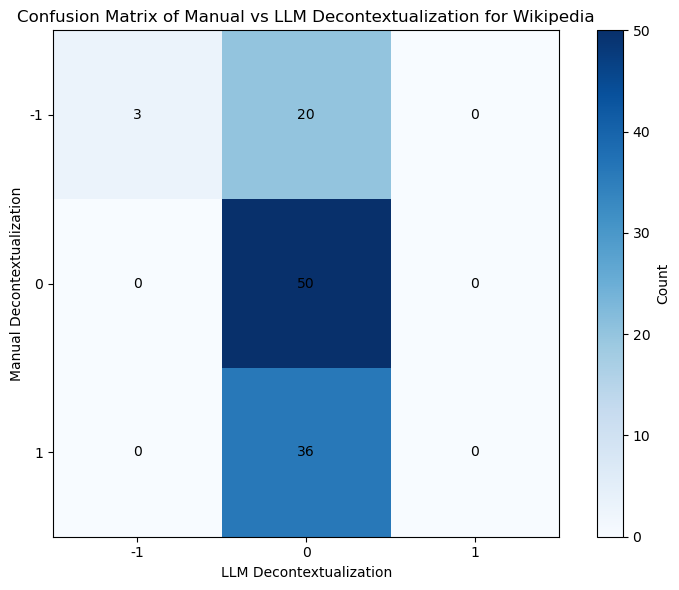

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for source = 'Wikipedia'
filtered_df = merged_df[merged_df['Source'] == 'Wikipedia']

# Define the possible values for both axes
categories = [-1, 0, 1]

# Create a confusion matrix using crosstab
confusion_matrix = pd.crosstab(
    filtered_df['is_decontextualized_manual'], 
    filtered_df['is_decontextualized_llm'], 
    rownames=['Manual'], 
    colnames=['LLM'], 
    dropna=False
).reindex(index=categories, columns=categories, fill_value=0)

# Display the confusion matrix
print(confusion_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')

# Add text annotations
for i in range(len(categories)):
    for j in range(len(categories)):
        plt.text(j, i, confusion_matrix.iloc[i, j], ha='center', va='center', color='black')

# Add labels and title
plt.xticks(ticks=range(len(categories)), labels=categories)
plt.yticks(ticks=range(len(categories)), labels=categories)
plt.xlabel('LLM Decontextualization')
plt.ylabel('Manual Decontextualization')
plt.title('Confusion Matrix of Manual vs LLM Decontextualization for Wikipedia')
plt.colorbar(label='Count')
plt.tight_layout()

# Show the plot
plt.show()


In [137]:
from sklearn.metrics import classification_report

# Ensure no missing values in the relevant columns
filtered_df = filtered_df.dropna(subset=['is_decontextualized_manual', 'is_decontextualized_llm'])

# Define true labels and predicted labels
y_true = filtered_df['is_decontextualized_manual']
y_pred = filtered_df['is_decontextualized_llm']

# Generate the classification report
report = classification_report(y_true, y_pred, labels=[-1, 0, 1], target_names=["Class -1", "Class 0", "Class 1"])

# Print the classification report
print(report)


              precision    recall  f1-score   support

    Class -1       1.00      0.13      0.23        23
     Class 0       0.47      1.00      0.64        50
     Class 1       0.00      0.00      0.00        36

    accuracy                           0.49       109
   macro avg       0.49      0.38      0.29       109
weighted avg       0.43      0.49      0.34       109



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

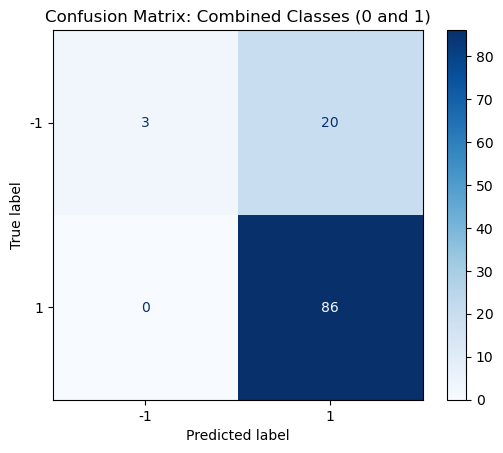

                          precision    recall  f1-score   support

                Class -1       1.00      0.13      0.23        23
Combined Class (0 and 1)       0.81      1.00      0.90        86

                accuracy                           0.82       109
               macro avg       0.91      0.57      0.56       109
            weighted avg       0.85      0.82      0.76       109



In [138]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Combine classes 0 and 1 into a single class (e.g., class 1)
new_y_true = filtered_df['is_decontextualized_manual'].replace({0: 1})
new_y_pred = filtered_df['is_decontextualized_llm'].replace({0: 1})

# Compute the confusion matrix
new_labels = [-1, 1]  # Class -1 and the combined class 1
new_cm = confusion_matrix(new_y_true, new_y_pred, labels=new_labels)

# Display the new confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=new_cm, display_labels=new_labels)
disp.plot(cmap='Blues', values_format='d')

# Add title
plt.title("Confusion Matrix: Combined Classes (0 and 1)")
plt.show()

# Compute the new classification report
new_report = classification_report(new_y_true, new_y_pred, labels=new_labels, target_names=["Class -1", "Combined Class (0 and 1)"])

# Print the classification report
print(new_report)


In [114]:
# Filter the DataFrame for source = 'Wikipedia' and score = 5
filtered_df = merged_df[(merged_df['Source'] == 'Wikipedia') & (merged_df['score'] == 5)]

# Select the first 10 rows of the specified columns
columns_to_display = ['context', 'question', 'decontextualized_question', 'answer', 'is_decontextualized_manual', 'score', 'critique']
filtered_rows = filtered_df[columns_to_display].head(10)

judegment_map = {
    1: 'Already decontextualized',
    0: 'Should be decontextualized',
    -1: 'N/A for decontextualization'
}

# Display the rows in the specified format
for index, row in filtered_rows.iterrows():
    print(f"Context: {row['context']}")
    print(f"Original question: {row['question']}")
    print(f"Decontextualized question: {row['decontextualized_question']}")
    print(f"Answer: {row['answer']}")
    print(f"Score: {row['score']}")
    print(f"Critique: {row['critique']}")
    print(f"Manual judgement: {judegment_map[row['is_decontextualized_manual']]}")
    print("-" * 50)


Context: במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות הברית בחברות במפלגה הקומוניסטית של ארצות הברית או באהדה כלפיה, והיו מטרה לחקירות נמרצות שנערכו על ידי גופים ממשלתיים או ועדות וסוכנויות אזרחיות. מושאי החקירות היו בעיקר עובדי ממשלת ארצות הברית, אנשים שהיו קשורים לתעשיית הבידור, מורים ופעילים בארגוני עובדים. לחשדות ניתנה אמינות, אף על פי שהעדויות שעל פיהן הועלו אותם חשדות היו לעיתים קרובות לא חד-משמעיות ואף מפוקפקות, הוערכה רמת מסוכנותו של הנאשם בקשריו עם ארגונים קומוניסטיים וארגוני שמאל באופן מוגזם מאוד. רבים מהמואשמים איבדו את מקום עבודתם והקריירה שלהם נהרסה; כמה אף נכלאו. רוב תקופות המאסר ניתנו בפסקי דין שבוטלו מאוחר יותר על ידי ערכאות גבוהות יותר; תקופות המאסר ניתנו על פי חוקים שבוטלו מאוחר יותר, לאחר שהוכרזו כמנוגדים לחוקת ארצות הברית. בדומה, גם פיטורי עובדים בעקבות האשמות דומות בוטלו והוכרזו לא חוקיים או בעייתיים מבחינה משפטית. הליכים לא משפטיים שהתקיימו בעקבות האשמות מקארתיסטיות היו נתונים מאוחר לביקורת ציבורית ונודעו לגנאי.
Original question: מתי האשימו אלפי אזרחי ארצות הברית

In [117]:
# Filter the DataFrame for source = 'Wikipedia' and score = 4
filtered_df = merged_df[(merged_df['Source'] == 'Wikipedia') & (merged_df['score'] == 4)]

# Select the first 10 rows of the specified columns
columns_to_display = ['context', 'question', 'decontextualized_question', 'answer', 'is_decontextualized_manual', 'score', 'critique']
filtered_rows = filtered_df[columns_to_display].head(10)

judegment_map = {
    1: 'Already decontextualized',
    0: 'Should be decontextualized',
    -1: 'N/A for decontextualization'
}

# Display the rows in the specified format
for index, row in filtered_rows.iterrows():
    print(f"Context: {row['context']}")
    print(f"Original question: {row['question']}")
    print(f"Decontextualized question: {row['decontextualized_question']}")
    print(f"Answer: {row['answer']}")
    print(f"Score: {row['score']}")
    print(f"Critique: {row['critique']}")
    print(f"Manual judgement: {judegment_map[row['is_decontextualized_manual']]}")
    print("-" * 50)


Context: בניית פרופילים של משתמשים נחשבת על ידי רבים כאיום פוטנציאלי על הפרטיות. מסיבה זו הגבילו חלק מהמדינות באמצעות חקיקה את המידע שניתן להשיג באמצעות עוגיות ואת אופן השימוש בעוגיות. ארצות הברית, למשל, קבעה חוקים נוקשים בכל הנוגע ליצירת עוגיות חדשות. חוקים אלו, אשר נקבעו בשנת 2000, נקבעו לאחר שנחשף כי המשרד ליישום המדיניות של הממשל האמריקאי נגד השימוש בסמים (ONDCP) בבית הלבן השתמש בעוגיות כדי לעקוב אחרי משתמשים שצפו בפרסומות נגד השימוש בסמים במטרה לבדוק האם משתמשים אלו נכנסו לאתרים התומכים בשימוש בסמים. דניאל בראנט, פעיל הדוגל בפרטיות המשתמשים באינטרנט, חשף כי ה-CIA שלח עוגיות קבועות למחשבי אזרחים במשך עשר שנים. ב-25 בדצמבר 2005 גילה בראנט כי הסוכנות לביטחון לאומי (ה-NSA) השאירה שתי עוגיות קבועות במחשבי מבקרים בגלל שדרוג תוכנה. לאחר שהנושא פורסם, הם ביטלו מיד את השימוש בהן.
Original question: למה משמשות עוגיות צד ג׳?
Decontextualized question: למה ממשלות ומוסדות ביון משתמשים בעוגיות צד ג׳?
Answer: שדרוג תוכנה
Score: 4
Critique: The decontextualized question reflects the context reaso

In [115]:
# Filter the DataFrame for source = 'Wikipedia' and score = 5
filtered_df = merged_df[(merged_df['Source'] == 'Wikipedia') & (merged_df['score'] == 1)]

# Select the first 10 rows of the specified columns
columns_to_display = ['context', 'question', 'decontextualized_question', 'answer', 'is_decontextualized_manual', 'score', 'critique']
filtered_rows = filtered_df[columns_to_display].head(10)

judegment_map = {
    1: 'Already decontextualized',
    0: 'Should be decontextualized',
    -1: 'N/A for decontextualization'
}

# Display the rows in the specified format
for index, row in filtered_rows.iterrows():
    print(f"Context: {row['context']}")
    print(f"Original question: {row['question']}")
    print(f"Decontextualized question: {row['decontextualized_question']}")
    print(f"Answer: {row['answer']}")
    print(f"Score: {row['score']}")
    print(f"Critique: {row['critique']}")
    print(f"Manual judgement: {judegment_map[row['is_decontextualized_manual']]}")
    print("-" * 50)


Context: כמה מדינות טענו כי הן היורשות של הקיסרות הרומית לאחר נפילתה של הקיסרות הרומית המערבית, הקיסרות הרומית הקדושה הייתה ניסיון להקים לתחייה את הקיסרות במערב, היא נוסדה בשנת 800 כאשר האפיפיור לאו השלישי הכתיר את מלך הפרנקים קרל הגדול כקיסר רומא ביום חג המולד, למרות זאת הקיסרות והמושב הקיסרי לא הפכו פורמליים במשך כמה עשורים. לאחר נפילת קונסטנטינופול, הכריזה על עצמה נסיכות מוסקבה כיורשת המסורת של הנצרות האורתודוקסית בקיסרות הביזנטית, והחשיבה את עצמה כרומא השלישית (כאשר היא מחשיבה את קונסטנטינופול כרומא השנייה).
Original question: מתי נפלה קונסטנטינופול?
Decontextualized question: לא ניתן לדיוק את השאלה ללא הקשר נוסף. מהטקסט לא ברור מתי בדיוק נפלה העיר קונסטנטינופול.
Answer: בשנת 800
Score: 1
Critique: The decontextualized question appropriately identifies the lack of information in the context to answer the original question, awarding a total score of 1 out of 5 as it cannot be fully self-contained or yield the same answer as the original.
Manual judgement: N/A for decontextualization

In [133]:
# Filter the DataFrame for source = 'Wikipedia' and score = 4
filtered_df = merged_df[
    (merged_df['Source'] == 'Wikipedia') &
    (merged_df['is_decontextualized_manual'] != merged_df['is_decontextualized_llm'])
]

# Select the first 10 rows of the specified columns
columns_to_display = ['context', 'question', 'decontextualized_question', 'answer', 'is_decontextualized_manual', 'is_decontextualized_llm', 'score', 'critique']
filtered_rows = filtered_df[columns_to_display].head(100)

judegment_map = {
    1: 'Already decontextualized',
    0: 'Should be decontextualized',
    -1: 'N/A for decontextualization'
}

# Display the rows in the specified format
for index, row in filtered_rows.iterrows():
    print(f"Context: {row['context']}")
    print(f"Original question: {row['question']}")
    print(f"Decontextualized question: {row['decontextualized_question']}")
    print(f"Answer: {row['answer']}")
    print(f"Score: {row['score']}")
    print(f"Critique: {row['critique']}")
    print(f"LLM judgement: {judegment_map[row['is_decontextualized_llm']]}")
    print(f"Manual judgement: {judegment_map[row['is_decontextualized_manual']]}")
    print("-" * 50)


Context: במהלך תקופת מקארתי הואשמו אלפים מאזרחי ארצות הברית בחברות במפלגה הקומוניסטית של ארצות הברית או באהדה כלפיה, והיו מטרה לחקירות נמרצות שנערכו על ידי גופים ממשלתיים או ועדות וסוכנויות אזרחיות. מושאי החקירות היו בעיקר עובדי ממשלת ארצות הברית, אנשים שהיו קשורים לתעשיית הבידור, מורים ופעילים בארגוני עובדים. לחשדות ניתנה אמינות, אף על פי שהעדויות שעל פיהן הועלו אותם חשדות היו לעיתים קרובות לא חד-משמעיות ואף מפוקפקות, הוערכה רמת מסוכנותו של הנאשם בקשריו עם ארגונים קומוניסטיים וארגוני שמאל באופן מוגזם מאוד. רבים מהמואשמים איבדו את מקום עבודתם והקריירה שלהם נהרסה; כמה אף נכלאו. רוב תקופות המאסר ניתנו בפסקי דין שבוטלו מאוחר יותר על ידי ערכאות גבוהות יותר; תקופות המאסר ניתנו על פי חוקים שבוטלו מאוחר יותר, לאחר שהוכרזו כמנוגדים לחוקת ארצות הברית. בדומה, גם פיטורי עובדים בעקבות האשמות דומות בוטלו והוכרזו לא חוקיים או בעייתיים מבחינה משפטית. הליכים לא משפטיים שהתקיימו בעקבות האשמות מקארתיסטיות היו נתונים מאוחר לביקורת ציבורית ונודעו לגנאי.
Original question: מתי האשימו אלפי אזרחי ארצות הברית

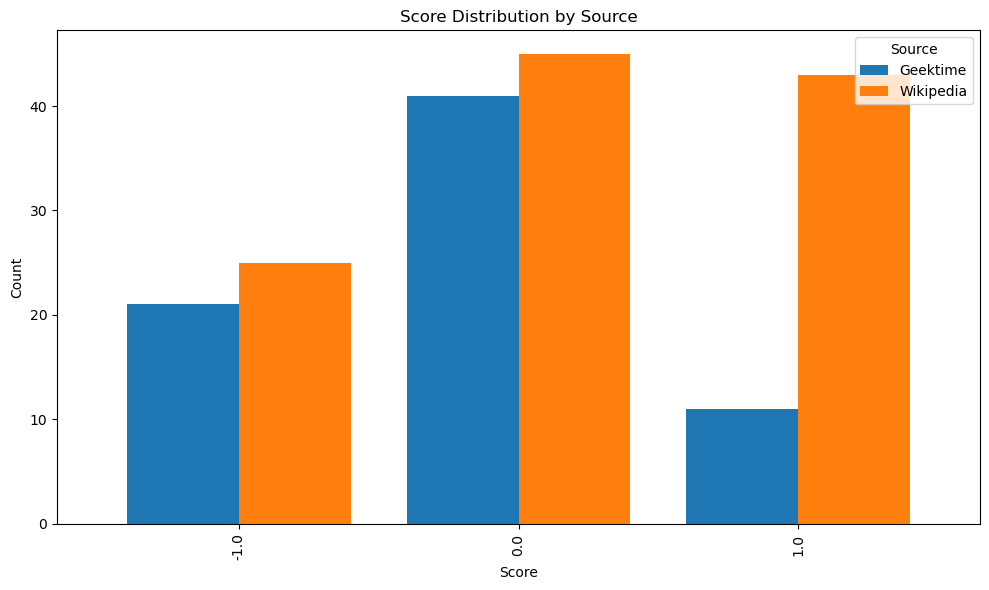

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each score broken down by source
is_decontextualized_manual_source_counts = merged_df.groupby(['is_decontextualized_manual', 'Source']).size().unstack(fill_value=0)

# Plot a bar chart
ax = is_decontextualized_manual_source_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Add chart labels and title
plt.title('Score Distribution by Source')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(title='Source', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


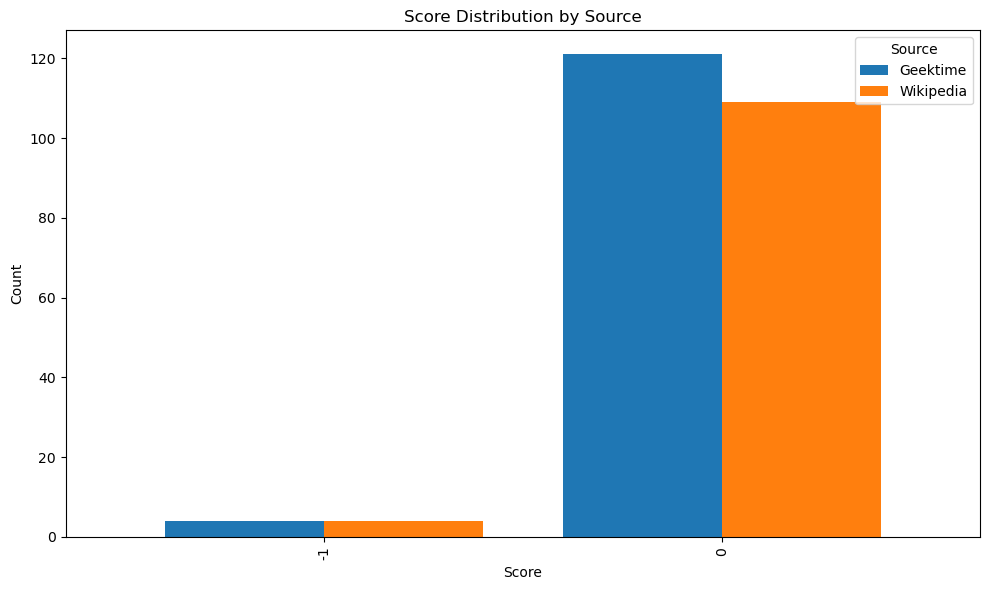

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each score broken down by source
is_decontextualized_llm_source_counts = merged_df.groupby(['is_decontextualized_llm', 'Source']).size().unstack(fill_value=0)

# Plot a bar chart
ax = is_decontextualized_llm_source_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Add chart labels and title
plt.title('Score Distribution by Source')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(title='Source', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


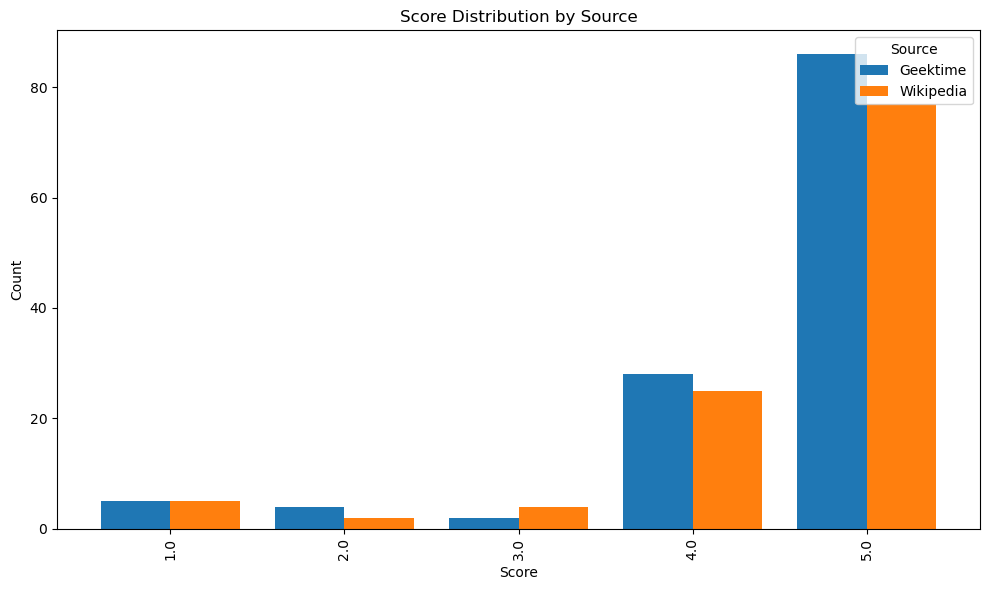

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each score broken down by source
score_source_counts = joined_df.groupby(['score', 'Source']).size().unstack(fill_value=0)

# Plot a bar chart
ax = score_source_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Add chart labels and title
plt.title('Score Distribution by Source')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(title='Source', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
joined_df[
    (joined_df['Source'] == 'Wikipedia') & 
    (joined_df['Is Decontextualized\n(0 = False, 1 = True, -1 = N/A)'] == 'Wikipedia')
]